In [1]:
#Imporing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression


#[26 Mei 2020]: ditambahkan agar angka random selalu sama ketika program dijalankan, sehingga hasil selalu sama
np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
#Reading data
learn_data = pd.read_csv("bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
learn_data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [3]:
#Defining columns
numerical_columns = ['number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan','area code']
outputs = ['churn']

#Input >16 Num coloums and 3 Cat coloums
#Output > 1 cat coloum

In [4]:
churn_data = learn_data[learn_data['churn'] == 'True']
notchurn_data = learn_data[learn_data['churn'] == 'False']

In [5]:
#Processing columns
scaler = StandardScaler()

##NUMERICAL
#convert our numerical columns to tensors
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)


#22 Juni 2020: memperbaiki cara menggunakan scaler
numerical_data = scaler.fit_transform(numerical_data)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

##CATEGORICAL
#convert the types for categorical columns to category
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')

#convert data in the four categorical columns into numpy arrays and then stack all the columns horizontally
st = learn_data['state'].cat.codes.values
ip = learn_data['international plan'].cat.codes.values
vm = learn_data['voice mail plan'].cat.codes.values
ac = learn_data['area code'].cat.codes.values

categorical_data = np.stack([st, ip, vm, ac], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
#convert the output numpy array into a tensor object
learn_data[outputs] = learn_data[outputs].astype(int)
outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

#print Outputs
print(numerical_data)
print(numerical_data.dtype)
print(numerical_data.shape)
print('_' * 75)

print(categorical_data)
print(categorical_data.dtype)
print(categorical_data.shape)
print('_' * 75)

tensor([[ 1.2349,  1.5668,  0.4766,  ..., -0.6012, -0.0857, -0.4279],
        [ 1.3079, -0.3337,  1.1245,  ..., -0.6012,  1.2412, -0.4279],
        [-0.5918,  1.1683,  0.6760,  ...,  0.2115,  0.6972, -1.1882],
        ...,
        [-0.5918,  0.0188,  0.4268,  ...,  0.6179,  1.3871,  0.3324],
        [-0.5918,  0.6248,  0.2275,  ...,  2.2434, -1.8770,  0.3324],
        [ 1.2349,  1.0030,  0.6261,  ..., -0.1948,  1.2412, -1.1882]])
torch.float32
torch.Size([3333, 14])
___________________________________________________________________________
tensor([[16,  0,  1,  1],
        [35,  0,  1,  1],
        [31,  0,  0,  1],
        ...,
        [39,  0,  0,  2],
        [ 6,  1,  0,  2],
        [42,  0,  1,  1]])
torch.int64
torch.Size([3333, 4])
___________________________________________________________________________


In [6]:
#Divide dataset into training, Valid  and Test sets
total_records = 3333

train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)

numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]

categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]

train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

#print divide dataset
print(train_records)
print(valid_records)
print(test_records)

1999
666
666


In [7]:
#define a class named Model, which will be used to train the model

from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(14, 100) #NUMERICAL
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)
        self.weights1 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(5))
        
        self.weights2 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights2, a=math.sqrt(5))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        
        #CATEGORICAL
        self.layer1_1 = nn.Embedding(51, 5) #51 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_1 = nn.BatchNorm1d(5)
        self.layer1_2 = nn.Embedding(2, 5) #2 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_2 = nn.BatchNorm1d(5)
        self.layer1_3 = nn.Embedding(2, 5) #2 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_3 = nn.BatchNorm1d(5)
        self.layer1_4 = nn.Embedding(3, 5) #3 unique data cat state coloum as input and 5 dimensi/vector size as output
        self.bn1_4 = nn.BatchNorm1d(5)
        
        self.layer2 = nn.Linear(120, 120)
        self.bn2 = nn.BatchNorm1d(120)
        
        #DECODER
        self.decoder_categorical_1 = nn.Linear(120,51)
        self.decoder_categorical_2 = nn.Linear(120,2)
        self.decoder_categorical_3 = nn.Linear(120,2)
        self.decoder_categorical_4 = nn.Linear(120,3)
                
        self.decoder_numerical = nn.Linear(120,14)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x4_embedding = self.layer1_4(x_categorical[:,3])
        x4_embedding = self.relu(x4_embedding)
        x4_embedding = self.bn1_4(x4_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding,x4_embedding], 1)
                
        x1_1 = torch.cat([x1, x_embedding], 1)
        x1_relu = self.relu(x1_1)
        
        #DECODER
        x2 = self.layer2(x1_relu)
        emb = self.relu(x2)
        x2 = self.bn2(emb)
                
        x2_weights1 = torch.mm(x2, self.weights1.t()) + self.bias1
        x2_weights2 = torch.mm(x2, self.weights2.t()) + self.bias2
        
        x3 = torch.cat([x2_weights1, x2_weights2], 1)
        
        categorical_1_decoded = self.decoder_categorical_1(x2)
        categorical_2_decoded = self.decoder_categorical_2(x2)
        categorical_3_decoded = self.decoder_categorical_3(x2)
        categorical_4_decoded = self.decoder_categorical_4(x2)
            
        numerical_decoded = self.decoder_numerical(x2)
                
        return emb, self.weights1, self.weights2, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, x3

In [8]:
model = Model()
print(model.decoder_numerical)

Linear(in_features=120, out_features=14, bias=True)


In [9]:
#define loss function & optimizer
# Defining churn:loyal weight ratio. churn_percentage=0.7 means churn:loyal weight ratio of 7:3.
# Setting churn_percentage=0.5 to get an unweighted model
#===============================================================================================
churn_percentage = 0.7

#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
loss_function_autoencoder = nn.CrossEntropyLoss() #classification - categorical

loss_function_mse = nn.MSELoss() #regression - numerical

# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#29 Juni 2020: menambahkan scheduler learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [10]:
#Training the data
epochs = 100 #Jumlah berapa kali dataset digunakan untuk train model
batch_size = 10

mean_losses_train = []
mean_losses_valid = []

mean_losses_train_autoencoder = []
mean_losses_valid_autoencoder = []

mean_losses_train_classification = []
mean_losses_valid_classification = []

best_loss_valid = np.inf

ae_ratio = 0.5
ae_scale = 0.1

for i in range(epochs):
    #===========================================================================================================
    #22 Juni 2020: rasio loss autoencoder dibuat mengikuti fungsi yang turun secara eksponensial dimulai dari 0,5.
    #Tujuannya agar semakin lama, pengaruh loss classification menjadi semakin kuat.
    #Penurunan rasio ini dibutuhkan karena tujuan utama model adalah klasifikasi
    #sedangkan autoencoder hanya sebagai tambahan untuk memperkuat kemampuan klasifikasi    
    #===========================================================================================================
    model.train()
    aggregated_losses_train = []
    aggregated_losses_valid = []
    
    aggregated_losses_autoencoder = []
    aggregated_losses_valid_autoencoder = []
    
    aggregated_losses_classification = []
    aggregated_losses_valid_classification = []
    
    mean_losses = []
    
    # 22 Juni 2020: ditambahkan random permutation untuk shuffle data training
    idxs = np.random.permutation(train_records)
    for j in range(train_records//batch_size):
        start_train = j*batch_size
        end_train = start_train+batch_size
        
        idxs_batch = idxs[start_train:end_train] #22 Juni 2020: untuk shuffle data training
        
        optimizer.zero_grad()
        
        # 22 Juni 2020: input diganti dengan categorical_train_data dan numerical_train_data
        train, weights1, weights2, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, train_embed = model(numerical_train_data[idxs_batch], categorical_train_data[idxs_batch]) # yg error 1
        
        # 22 Juni 2020: nama loss dibedakan antara train dan validasi, outputs diganti jadi train_outputs
        classification_loss_train = loss_function(train_embed, train_outputs[idxs_batch])

        categorical_1_loss_train = loss_function_autoencoder(categorical_1_decoded, categorical_data[start_train:end_train][:,0])
        categorical_2_loss_train = loss_function_autoencoder(categorical_2_decoded, categorical_data[start_train:end_train][:,1])
        categorical_3_loss_train = loss_function_autoencoder(categorical_3_decoded, categorical_data[start_train:end_train][:,2])
        categorical_4_loss_train = loss_function_autoencoder(categorical_4_decoded, categorical_data[start_train:end_train][:,3])

        numerical_loss_train = loss_function_mse(numerical_decoded, numerical_train_data[start_train:end_train])
   
        autoencoder_loss_train = ae_scale*(categorical_1_loss_train + categorical_2_loss_train + categorical_3_loss_train + categorical_4_loss_train + numerical_loss_train)
        single_loss = ((1-ae_ratio)*classification_loss_train) + (ae_ratio*autoencoder_loss_train)
        
        aggregated_losses_autoencoder.append(autoencoder_loss_train)
        aggregated_losses_classification.append(classification_loss_train)
        aggregated_losses_train.append(single_loss)

        print(f'iteration: {j:3} loss: {single_loss.item():10.8f}')

        single_loss.backward()
        optimizer.step()

    aggregated_losses_autoencoder = torch.stack(aggregated_losses_autoencoder)
    aggregated_losses_classification = torch.stack(aggregated_losses_classification)
    aggregated_losses_train = torch.stack(aggregated_losses_train)
        
    mean_losses_autoencoder = torch.mean(aggregated_losses_autoencoder)
    mean_losses_classification = torch.mean(aggregated_losses_classification)
    mean_losses = torch.mean(aggregated_losses_train)
        
    print(f'epoch: {i:3} mean loss training: {mean_losses.item():10.8f}')
        
    mean_losses_train_autoencoder.append(mean_losses_autoencoder)
    mean_losses_train_classification.append(mean_losses_classification)
    mean_losses_train.append(mean_losses)
    
    # ==============================================================================================
    # validation
    # ==============================================================================================

    model.eval()
    with torch.set_grad_enabled(False):
        for k in range((valid_records//batch_size)):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size
            
            # 22 Juni 2020: input diganti dengan categorical_valid_data dan numerical_valid_data
            valid, weights1, weights2, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, valid_embed = model(numerical_valid_data[start_valid:end_valid], categorical_valid_data[start_valid:end_valid]) # kenapa disini harus ada 2 variabel prefix
            
            # 22 Juni 2020: nama loss dibedakan antara train dan validasi, outputs diganti jadi valid_outputs
            classification_loss_valid = loss_function(valid_embed, valid_outputs[start_valid:end_valid])
 
            categorical_1_loss_valid = loss_function_autoencoder(categorical_1_decoded, categorical_data[start_valid:end_valid][:,0])
            categorical_2_loss_valid = loss_function_autoencoder(categorical_2_decoded, categorical_data[start_valid:end_valid][:,1])
            categorical_3_loss_valid = loss_function_autoencoder(categorical_3_decoded, categorical_data[start_valid:end_valid][:,2])
            categorical_4_loss_valid = loss_function_autoencoder(categorical_4_decoded, categorical_data[start_valid:end_valid][:,3])

            numerical_loss_valid = loss_function_mse(numerical_decoded, numerical_valid_data[start_valid:end_valid])
            
            autoencoder_loss_valid = ae_scale*(categorical_1_loss_valid + categorical_2_loss_valid + categorical_3_loss_valid + categorical_4_loss_valid + numerical_loss_valid)
            valid_loss = ((1-ae_ratio)*classification_loss_valid) + (ae_ratio*autoencoder_loss_valid)

            aggregated_losses_valid_autoencoder.append(autoencoder_loss_valid)
            aggregated_losses_valid_classification.append(classification_loss_valid)
            aggregated_losses_valid.append(valid_loss)

    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    mean_loss_valid_autoencoder = torch.mean(torch.stack(aggregated_losses_valid_autoencoder))
    mean_loss_valid_classification = torch.mean(torch.stack(aggregated_losses_valid_classification))
    
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
    
    #======================================================================
    #26 Mei 2020> Model disimpan ketika loss terrendah bukan di epoch akhir
    #======================================================================    
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "model_autoencoder.pth")
        best_epoch = i        
    
    mean_losses_valid.append(mean_losses_valid)
    mean_losses_valid_autoencoder.append(mean_loss_valid_autoencoder)
    mean_losses_valid_classification.append(mean_loss_valid_classification)

    scheduler.step()

iteration:   0 loss: 0.82668442
iteration:   1 loss: 0.80843318
iteration:   2 loss: 0.76398981
iteration:   3 loss: 0.77831107
iteration:   4 loss: 0.80060101
iteration:   5 loss: 0.77177453
iteration:   6 loss: 0.79540241
iteration:   7 loss: 0.74564236
iteration:   8 loss: 0.77234554
iteration:   9 loss: 0.74978614
iteration:  10 loss: 0.82741183
iteration:  11 loss: 0.67206293
iteration:  12 loss: 0.67190289
iteration:  13 loss: 0.85445410
iteration:  14 loss: 0.70516431
iteration:  15 loss: 0.77858388
iteration:  16 loss: 0.75228971
iteration:  17 loss: 0.71701169
iteration:  18 loss: 0.81042731
iteration:  19 loss: 0.86397189
iteration:  20 loss: 0.74170065
iteration:  21 loss: 0.73878348
iteration:  22 loss: 0.71958733
iteration:  23 loss: 0.73684192
iteration:  24 loss: 0.79149723
iteration:  25 loss: 0.77421522
iteration:  26 loss: 0.70062649
iteration:  27 loss: 0.74067223
iteration:  28 loss: 0.67867410
iteration:  29 loss: 0.67117572
iteration:  30 loss: 0.62647754
iteratio

iteration:  56 loss: 0.78501970
iteration:  57 loss: 0.59317011
iteration:  58 loss: 0.52399915
iteration:  59 loss: 0.78744221
iteration:  60 loss: 0.49055701
iteration:  61 loss: 0.68117738
iteration:  62 loss: 0.45594853
iteration:  63 loss: 0.86431789
iteration:  64 loss: 0.54416960
iteration:  65 loss: 0.55846220
iteration:  66 loss: 0.60650390
iteration:  67 loss: 0.79268789
iteration:  68 loss: 0.59535694
iteration:  69 loss: 0.85548770
iteration:  70 loss: 0.44685191
iteration:  71 loss: 0.57100224
iteration:  72 loss: 0.46945989
iteration:  73 loss: 0.50945765
iteration:  74 loss: 0.51242650
iteration:  75 loss: 0.61872667
iteration:  76 loss: 0.56909990
iteration:  77 loss: 0.54317141
iteration:  78 loss: 0.71163988
iteration:  79 loss: 0.52189767
iteration:  80 loss: 0.50565988
iteration:  81 loss: 0.48870558
iteration:  82 loss: 0.50137156
iteration:  83 loss: 0.50521028
iteration:  84 loss: 0.48083949
iteration:  85 loss: 0.62644529
iteration:  86 loss: 0.55753398
iteratio

iteration: 112 loss: 0.50539881
iteration: 113 loss: 0.49954149
iteration: 114 loss: 0.47559792
iteration: 115 loss: 0.49806473
iteration: 116 loss: 0.60432577
iteration: 117 loss: 0.47888905
iteration: 118 loss: 0.43472916
iteration: 119 loss: 0.96627760
iteration: 120 loss: 0.42243776
iteration: 121 loss: 0.46198183
iteration: 122 loss: 0.44604456
iteration: 123 loss: 0.46377128
iteration: 124 loss: 0.74542582
iteration: 125 loss: 0.58439511
iteration: 126 loss: 0.41347882
iteration: 127 loss: 0.49734047
iteration: 128 loss: 0.38876802
iteration: 129 loss: 0.65315604
iteration: 130 loss: 0.44505495
iteration: 131 loss: 0.54540700
iteration: 132 loss: 0.40278295
iteration: 133 loss: 0.45924473
iteration: 134 loss: 0.78987193
iteration: 135 loss: 0.60362017
iteration: 136 loss: 0.43956855
iteration: 137 loss: 0.48843163
iteration: 138 loss: 1.00363052
iteration: 139 loss: 0.48075193
iteration: 140 loss: 0.57257473
iteration: 141 loss: 0.45026892
iteration: 142 loss: 0.70470619
iteratio

iteration: 173 loss: 0.51740140
iteration: 174 loss: 0.65722078
iteration: 175 loss: 0.55442351
iteration: 176 loss: 0.43993551
iteration: 177 loss: 0.89278889
iteration: 178 loss: 0.54607379
iteration: 179 loss: 0.52930701
iteration: 180 loss: 0.44511959
iteration: 181 loss: 0.53435045
iteration: 182 loss: 0.44071311
iteration: 183 loss: 0.54151762
iteration: 184 loss: 0.47688800
iteration: 185 loss: 0.43286574
iteration: 186 loss: 0.48337248
iteration: 187 loss: 0.45586509
iteration: 188 loss: 0.52471048
iteration: 189 loss: 0.43613186
iteration: 190 loss: 0.44584933
iteration: 191 loss: 0.45628417
iteration: 192 loss: 0.42157662
iteration: 193 loss: 0.54123509
iteration: 194 loss: 0.35174403
iteration: 195 loss: 0.45820743
iteration: 196 loss: 0.66159785
iteration: 197 loss: 0.73342681
iteration: 198 loss: 0.46725562
epoch:   3 mean loss training: 0.52445740
epoch:   3 mean loss validation: 0.52279240
iteration:   0 loss: 0.53118420
iteration:   1 loss: 0.49098653
iteration:   2 los

iteration:  28 loss: 0.54957187
iteration:  29 loss: 0.82380664
iteration:  30 loss: 0.52889901
iteration:  31 loss: 0.50940549
iteration:  32 loss: 0.41194430
iteration:  33 loss: 0.47011960
iteration:  34 loss: 0.56356400
iteration:  35 loss: 0.43385658
iteration:  36 loss: 0.42819950
iteration:  37 loss: 0.40527818
iteration:  38 loss: 0.43738478
iteration:  39 loss: 0.40961978
iteration:  40 loss: 0.53064322
iteration:  41 loss: 0.47005594
iteration:  42 loss: 0.47367430
iteration:  43 loss: 0.60328639
iteration:  44 loss: 0.41596261
iteration:  45 loss: 0.45642871
iteration:  46 loss: 0.43292627
iteration:  47 loss: 0.41466182
iteration:  48 loss: 0.92801440
iteration:  49 loss: 0.48300397
iteration:  50 loss: 0.49493667
iteration:  51 loss: 0.50390375
iteration:  52 loss: 0.44685107
iteration:  53 loss: 0.61237961
iteration:  54 loss: 0.95017374
iteration:  55 loss: 0.40452841
iteration:  56 loss: 0.46541092
iteration:  57 loss: 0.51104534
iteration:  58 loss: 0.44995898
iteratio

iteration:  86 loss: 0.41090131
iteration:  87 loss: 0.42491186
iteration:  88 loss: 0.44856304
iteration:  89 loss: 0.46437734
iteration:  90 loss: 0.42933536
iteration:  91 loss: 0.43333355
iteration:  92 loss: 0.42159265
iteration:  93 loss: 0.46741793
iteration:  94 loss: 0.41770017
iteration:  95 loss: 0.45439011
iteration:  96 loss: 0.40476006
iteration:  97 loss: 0.50628018
iteration:  98 loss: 0.53514928
iteration:  99 loss: 0.37678435
iteration: 100 loss: 0.43805999
iteration: 101 loss: 0.62287045
iteration: 102 loss: 0.55554354
iteration: 103 loss: 0.52221757
iteration: 104 loss: 0.61809492
iteration: 105 loss: 0.50989777
iteration: 106 loss: 0.40212375
iteration: 107 loss: 0.40784743
iteration: 108 loss: 0.48603404
iteration: 109 loss: 0.50393486
iteration: 110 loss: 0.68435472
iteration: 111 loss: 0.60857391
iteration: 112 loss: 0.41503328
iteration: 113 loss: 0.48131827
iteration: 114 loss: 0.77686143
iteration: 115 loss: 0.39376479
iteration: 116 loss: 0.45534441
iteratio

iteration: 144 loss: 0.37593102
iteration: 145 loss: 0.47615829
iteration: 146 loss: 0.51068151
iteration: 147 loss: 0.50653881
iteration: 148 loss: 0.41266602
iteration: 149 loss: 0.50325453
iteration: 150 loss: 0.41196647
iteration: 151 loss: 0.36071697
iteration: 152 loss: 0.36504480
iteration: 153 loss: 0.43882918
iteration: 154 loss: 0.43674579
iteration: 155 loss: 0.41074812
iteration: 156 loss: 0.47848487
iteration: 157 loss: 0.51680297
iteration: 158 loss: 0.64660281
iteration: 159 loss: 0.44515300
iteration: 160 loss: 0.47876462
iteration: 161 loss: 0.52630460
iteration: 162 loss: 0.44541195
iteration: 163 loss: 0.54930717
iteration: 164 loss: 0.54996741
iteration: 165 loss: 0.55100155
iteration: 166 loss: 0.74576962
iteration: 167 loss: 0.42587560
iteration: 168 loss: 0.52596855
iteration: 169 loss: 0.38989246
iteration: 170 loss: 0.45420951
iteration: 171 loss: 0.58151090
iteration: 172 loss: 0.64878869
iteration: 173 loss: 0.56352019
iteration: 174 loss: 0.52906203
iteratio

epoch:   8 mean loss validation: 0.52370906
iteration:   0 loss: 0.56379020
iteration:   1 loss: 0.42323157
iteration:   2 loss: 0.41667357
iteration:   3 loss: 0.45449021
iteration:   4 loss: 0.71403658
iteration:   5 loss: 0.47725973
iteration:   6 loss: 0.46343303
iteration:   7 loss: 0.46978861
iteration:   8 loss: 0.38208565
iteration:   9 loss: 0.36219063
iteration:  10 loss: 0.70713955
iteration:  11 loss: 0.42103380
iteration:  12 loss: 0.51284444
iteration:  13 loss: 0.54543734
iteration:  14 loss: 0.49329469
iteration:  15 loss: 0.46054450
iteration:  16 loss: 0.39985824
iteration:  17 loss: 1.00820470
iteration:  18 loss: 0.58120763
iteration:  19 loss: 0.44435048
iteration:  20 loss: 0.37480360
iteration:  21 loss: 0.74513698
iteration:  22 loss: 0.42888081
iteration:  23 loss: 0.42407441
iteration:  24 loss: 0.66309947
iteration:  25 loss: 0.39529228
iteration:  26 loss: 0.47095233
iteration:  27 loss: 0.45016038
iteration:  28 loss: 0.46377987
iteration:  29 loss: 0.43105

iteration:  59 loss: 0.36181283
iteration:  60 loss: 0.42648384
iteration:  61 loss: 0.60035121
iteration:  62 loss: 0.44192606
iteration:  63 loss: 0.45893925
iteration:  64 loss: 0.45465371
iteration:  65 loss: 0.40069374
iteration:  66 loss: 0.58763778
iteration:  67 loss: 0.44629627
iteration:  68 loss: 0.37711781
iteration:  69 loss: 0.53534067
iteration:  70 loss: 0.41739380
iteration:  71 loss: 0.41207916
iteration:  72 loss: 0.54426301
iteration:  73 loss: 0.49103719
iteration:  74 loss: 0.42407933
iteration:  75 loss: 0.51424873
iteration:  76 loss: 0.43534899
iteration:  77 loss: 0.54394001
iteration:  78 loss: 0.43364298
iteration:  79 loss: 0.70239252
iteration:  80 loss: 0.51635158
iteration:  81 loss: 0.36372221
iteration:  82 loss: 0.43384793
iteration:  83 loss: 0.52847242
iteration:  84 loss: 0.48697609
iteration:  85 loss: 0.39621076
iteration:  86 loss: 0.40600485
iteration:  87 loss: 0.47388652
iteration:  88 loss: 0.42746633
iteration:  89 loss: 0.37526006
iteratio

iteration: 114 loss: 0.39134645
iteration: 115 loss: 0.52491063
iteration: 116 loss: 0.53776145
iteration: 117 loss: 0.39363921
iteration: 118 loss: 0.44725075
iteration: 119 loss: 0.45996183
iteration: 120 loss: 0.49367219
iteration: 121 loss: 0.46446368
iteration: 122 loss: 0.64064342
iteration: 123 loss: 0.48325640
iteration: 124 loss: 0.55535126
iteration: 125 loss: 0.41440755
iteration: 126 loss: 0.61655569
iteration: 127 loss: 0.44674286
iteration: 128 loss: 0.45178449
iteration: 129 loss: 0.42087787
iteration: 130 loss: 0.64581668
iteration: 131 loss: 0.49690771
iteration: 132 loss: 0.42646360
iteration: 133 loss: 0.44975033
iteration: 134 loss: 0.50380623
iteration: 135 loss: 0.41471335
iteration: 136 loss: 0.46665472
iteration: 137 loss: 0.42329389
iteration: 138 loss: 0.42949671
iteration: 139 loss: 0.43962505
iteration: 140 loss: 0.48411942
iteration: 141 loss: 0.45658419
iteration: 142 loss: 0.61646873
iteration: 143 loss: 0.43364418
iteration: 144 loss: 0.41387749
iteratio

iteration: 177 loss: 0.44724759
iteration: 178 loss: 0.41310668
iteration: 179 loss: 0.36864531
iteration: 180 loss: 0.62269223
iteration: 181 loss: 0.42862454
iteration: 182 loss: 0.57394290
iteration: 183 loss: 0.46178898
iteration: 184 loss: 0.47168458
iteration: 185 loss: 0.39568612
iteration: 186 loss: 0.47597441
iteration: 187 loss: 0.74712038
iteration: 188 loss: 0.44023094
iteration: 189 loss: 0.40915596
iteration: 190 loss: 0.48139513
iteration: 191 loss: 0.94319868
iteration: 192 loss: 0.56775689
iteration: 193 loss: 0.38389423
iteration: 194 loss: 0.42082685
iteration: 195 loss: 0.42058796
iteration: 196 loss: 0.42189658
iteration: 197 loss: 0.50476766
iteration: 198 loss: 0.42817146
epoch:  12 mean loss training: 0.47740597
epoch:  12 mean loss validation: 0.52214336
iteration:   0 loss: 0.87488306
iteration:   1 loss: 0.51212525
iteration:   2 loss: 0.43091112
iteration:   3 loss: 0.67268670
iteration:   4 loss: 0.43829882
iteration:   5 loss: 0.50005007
iteration:   6 los

iteration:  30 loss: 0.36424515
iteration:  31 loss: 0.39591166
iteration:  32 loss: 0.44773632
iteration:  33 loss: 0.43274096
iteration:  34 loss: 0.66238022
iteration:  35 loss: 0.48483065
iteration:  36 loss: 0.46989018
iteration:  37 loss: 0.75583178
iteration:  38 loss: 0.58452678
iteration:  39 loss: 0.37958258
iteration:  40 loss: 0.42620736
iteration:  41 loss: 0.47854152
iteration:  42 loss: 0.39659649
iteration:  43 loss: 0.39804786
iteration:  44 loss: 0.62393081
iteration:  45 loss: 0.45741495
iteration:  46 loss: 0.66366482
iteration:  47 loss: 0.48555321
iteration:  48 loss: 0.45285472
iteration:  49 loss: 0.44727823
iteration:  50 loss: 0.55154526
iteration:  51 loss: 0.43891633
iteration:  52 loss: 0.55232173
iteration:  53 loss: 0.52410859
iteration:  54 loss: 0.72909296
iteration:  55 loss: 0.37995580
iteration:  56 loss: 0.42773819
iteration:  57 loss: 0.45201221
iteration:  58 loss: 0.46859857
iteration:  59 loss: 0.51368153
iteration:  60 loss: 0.83837211
iteratio

iteration:  92 loss: 0.43961108
iteration:  93 loss: 0.35241315
iteration:  94 loss: 0.40275723
iteration:  95 loss: 0.40672678
iteration:  96 loss: 0.72977257
iteration:  97 loss: 0.40168586
iteration:  98 loss: 0.50320762
iteration:  99 loss: 0.44326660
iteration: 100 loss: 0.48782706
iteration: 101 loss: 0.51987094
iteration: 102 loss: 0.48723668
iteration: 103 loss: 0.40434152
iteration: 104 loss: 0.45442712
iteration: 105 loss: 0.51647323
iteration: 106 loss: 0.45014334
iteration: 107 loss: 0.40529019
iteration: 108 loss: 0.44817215
iteration: 109 loss: 0.43815345
iteration: 110 loss: 0.37441394
iteration: 111 loss: 0.43264472
iteration: 112 loss: 0.46456391
iteration: 113 loss: 0.40647811
iteration: 114 loss: 0.41830680
iteration: 115 loss: 0.54641366
iteration: 116 loss: 0.59209991
iteration: 117 loss: 0.48219153
iteration: 118 loss: 0.50600368
iteration: 119 loss: 0.84450752
iteration: 120 loss: 0.68555582
iteration: 121 loss: 0.50413853
iteration: 122 loss: 0.40969950
iteratio

iteration: 154 loss: 0.38559738
iteration: 155 loss: 0.41453791
iteration: 156 loss: 0.54553127
iteration: 157 loss: 0.46376723
iteration: 158 loss: 0.36108303
iteration: 159 loss: 0.42152038
iteration: 160 loss: 0.99481750
iteration: 161 loss: 0.42565912
iteration: 162 loss: 0.66346800
iteration: 163 loss: 0.40865809
iteration: 164 loss: 0.37221819
iteration: 165 loss: 0.42696789
iteration: 166 loss: 0.39170763
iteration: 167 loss: 0.48315388
iteration: 168 loss: 0.43235230
iteration: 169 loss: 0.36580676
iteration: 170 loss: 0.41282803
iteration: 171 loss: 0.49371195
iteration: 172 loss: 0.40302587
iteration: 173 loss: 0.47197661
iteration: 174 loss: 0.70703673
iteration: 175 loss: 0.67403603
iteration: 176 loss: 0.45651412
iteration: 177 loss: 0.52977747
iteration: 178 loss: 0.50532180
iteration: 179 loss: 0.33576524
iteration: 180 loss: 0.40850046
iteration: 181 loss: 0.41301483
iteration: 182 loss: 0.48057681
iteration: 183 loss: 0.49097627
iteration: 184 loss: 0.67348683
iteratio

iteration:  10 loss: 0.42449501
iteration:  11 loss: 0.41115871
iteration:  12 loss: 0.37897828
iteration:  13 loss: 0.62440735
iteration:  14 loss: 0.43111563
iteration:  15 loss: 0.58543783
iteration:  16 loss: 0.40667218
iteration:  17 loss: 0.49799654
iteration:  18 loss: 0.80413067
iteration:  19 loss: 0.42951950
iteration:  20 loss: 0.38251507
iteration:  21 loss: 0.52775133
iteration:  22 loss: 0.41538078
iteration:  23 loss: 0.45646572
iteration:  24 loss: 0.46081007
iteration:  25 loss: 0.46240738
iteration:  26 loss: 0.40077493
iteration:  27 loss: 0.52091849
iteration:  28 loss: 0.45991710
iteration:  29 loss: 0.40768537
iteration:  30 loss: 0.38494721
iteration:  31 loss: 0.48333609
iteration:  32 loss: 0.59087610
iteration:  33 loss: 0.45480826
iteration:  34 loss: 0.52223766
iteration:  35 loss: 0.47570866
iteration:  36 loss: 0.48518652
iteration:  37 loss: 0.41301745
iteration:  38 loss: 0.72620225
iteration:  39 loss: 0.34996971
iteration:  40 loss: 0.50248361
iteratio

iteration:  72 loss: 0.41140339
iteration:  73 loss: 0.67344022
iteration:  74 loss: 0.63204300
iteration:  75 loss: 0.65147597
iteration:  76 loss: 0.38915622
iteration:  77 loss: 0.48422301
iteration:  78 loss: 0.45062810
iteration:  79 loss: 0.47134972
iteration:  80 loss: 0.41366804
iteration:  81 loss: 0.36469468
iteration:  82 loss: 0.36556259
iteration:  83 loss: 0.45539367
iteration:  84 loss: 0.54233658
iteration:  85 loss: 0.38299149
iteration:  86 loss: 0.59110117
iteration:  87 loss: 0.45030445
iteration:  88 loss: 0.53885150
iteration:  89 loss: 0.48902601
iteration:  90 loss: 0.42804733
iteration:  91 loss: 0.48122799
iteration:  92 loss: 0.60399675
iteration:  93 loss: 0.38672152
iteration:  94 loss: 0.41830346
iteration:  95 loss: 0.78633392
iteration:  96 loss: 0.56066227
iteration:  97 loss: 0.43944877
iteration:  98 loss: 0.41647208
iteration:  99 loss: 0.39298958
iteration: 100 loss: 0.44656038
iteration: 101 loss: 0.37545806
iteration: 102 loss: 0.43256569
iteratio

iteration: 133 loss: 0.40544981
iteration: 134 loss: 0.51690924
iteration: 135 loss: 0.63616621
iteration: 136 loss: 0.58978266
iteration: 137 loss: 0.48718518
iteration: 138 loss: 0.35558355
iteration: 139 loss: 0.63230944
iteration: 140 loss: 0.62597525
iteration: 141 loss: 0.45893794
iteration: 142 loss: 0.50704592
iteration: 143 loss: 0.55697715
iteration: 144 loss: 0.48304695
iteration: 145 loss: 0.39380345
iteration: 146 loss: 0.53084421
iteration: 147 loss: 0.41898334
iteration: 148 loss: 0.44459721
iteration: 149 loss: 0.38667893
iteration: 150 loss: 0.42930168
iteration: 151 loss: 0.33428705
iteration: 152 loss: 0.39506164
iteration: 153 loss: 0.40842482
iteration: 154 loss: 0.48328674
iteration: 155 loss: 0.61985189
iteration: 156 loss: 0.40882143
iteration: 157 loss: 0.50694901
iteration: 158 loss: 0.37607267
iteration: 159 loss: 0.40001211
iteration: 160 loss: 0.79242814
iteration: 161 loss: 0.60068882
iteration: 162 loss: 0.45717958
iteration: 163 loss: 0.43564102
iteratio

iteration: 187 loss: 0.62341225
iteration: 188 loss: 0.50122976
iteration: 189 loss: 0.45202291
iteration: 190 loss: 0.40692770
iteration: 191 loss: 0.46129820
iteration: 192 loss: 0.35378820
iteration: 193 loss: 0.58771163
iteration: 194 loss: 0.48254061
iteration: 195 loss: 0.42671129
iteration: 196 loss: 0.42033511
iteration: 197 loss: 0.43078533
iteration: 198 loss: 0.62975132
epoch:  21 mean loss training: 0.46218628
epoch:  21 mean loss validation: 0.51451862
iteration:   0 loss: 0.53042430
iteration:   1 loss: 0.73174405
iteration:   2 loss: 0.41172352
iteration:   3 loss: 0.42993057
iteration:   4 loss: 0.36910599
iteration:   5 loss: 0.37713069
iteration:   6 loss: 0.68446529
iteration:   7 loss: 0.71930254
iteration:   8 loss: 0.40784800
iteration:   9 loss: 0.35494295
iteration:  10 loss: 0.40950030
iteration:  11 loss: 0.43423030
iteration:  12 loss: 0.38278171
iteration:  13 loss: 0.40892404
iteration:  14 loss: 0.48213339
iteration:  15 loss: 0.43340445
iteration:  16 los

iteration:  43 loss: 0.42704216
iteration:  44 loss: 0.38421047
iteration:  45 loss: 0.35860920
iteration:  46 loss: 0.63036340
iteration:  47 loss: 0.44576928
iteration:  48 loss: 0.40932047
iteration:  49 loss: 0.44341522
iteration:  50 loss: 0.46935585
iteration:  51 loss: 0.38915390
iteration:  52 loss: 0.64057416
iteration:  53 loss: 0.55832124
iteration:  54 loss: 0.71701097
iteration:  55 loss: 0.38226026
iteration:  56 loss: 0.43368012
iteration:  57 loss: 0.43859899
iteration:  58 loss: 0.60546672
iteration:  59 loss: 0.45657569
iteration:  60 loss: 0.36878946
iteration:  61 loss: 0.47142583
iteration:  62 loss: 0.42863646
iteration:  63 loss: 0.43163088
iteration:  64 loss: 0.39973497
iteration:  65 loss: 0.63812947
iteration:  66 loss: 0.46719366
iteration:  67 loss: 0.46733433
iteration:  68 loss: 0.38915002
iteration:  69 loss: 0.44680262
iteration:  70 loss: 0.41107589
iteration:  71 loss: 0.56565076
iteration:  72 loss: 0.41030422
iteration:  73 loss: 0.45215267
iteratio

iteration:  98 loss: 0.44764671
iteration:  99 loss: 0.44553202
iteration: 100 loss: 0.39364278
iteration: 101 loss: 0.62835157
iteration: 102 loss: 0.67447448
iteration: 103 loss: 0.45667797
iteration: 104 loss: 0.61062092
iteration: 105 loss: 0.39047167
iteration: 106 loss: 0.41136745
iteration: 107 loss: 0.41628000
iteration: 108 loss: 0.43937218
iteration: 109 loss: 0.39115578
iteration: 110 loss: 0.40293795
iteration: 111 loss: 0.42336845
iteration: 112 loss: 0.40335116
iteration: 113 loss: 0.43749169
iteration: 114 loss: 0.51736814
iteration: 115 loss: 0.39949596
iteration: 116 loss: 0.44301838
iteration: 117 loss: 0.49633881
iteration: 118 loss: 0.55788201
iteration: 119 loss: 0.55613357
iteration: 120 loss: 0.51130271
iteration: 121 loss: 0.72468460
iteration: 122 loss: 0.37633076
iteration: 123 loss: 0.43572724
iteration: 124 loss: 0.70565999
iteration: 125 loss: 0.49455461
iteration: 126 loss: 0.37999314
iteration: 127 loss: 0.37999445
iteration: 128 loss: 0.38077500
iteratio

iteration: 159 loss: 0.56295407
iteration: 160 loss: 0.41776529
iteration: 161 loss: 0.40541661
iteration: 162 loss: 0.50368798
iteration: 163 loss: 0.34791130
iteration: 164 loss: 0.40787557
iteration: 165 loss: 0.56970942
iteration: 166 loss: 0.39279678
iteration: 167 loss: 0.49102578
iteration: 168 loss: 0.37166390
iteration: 169 loss: 0.42073107
iteration: 170 loss: 0.39557084
iteration: 171 loss: 0.42205724
iteration: 172 loss: 0.37695390
iteration: 173 loss: 0.44387484
iteration: 174 loss: 0.38302690
iteration: 175 loss: 0.43985310
iteration: 176 loss: 0.47119462
iteration: 177 loss: 0.46616057
iteration: 178 loss: 0.48986244
iteration: 179 loss: 0.34563527
iteration: 180 loss: 0.42135864
iteration: 181 loss: 0.38462555
iteration: 182 loss: 0.35219049
iteration: 183 loss: 0.39146015
iteration: 184 loss: 0.50381303
iteration: 185 loss: 0.40153268
iteration: 186 loss: 0.42956749
iteration: 187 loss: 0.40405566
iteration: 188 loss: 0.42066810
iteration: 189 loss: 0.39486066
iteratio

iteration:  15 loss: 0.43703216
iteration:  16 loss: 0.37522060
iteration:  17 loss: 0.38253731
iteration:  18 loss: 0.43924505
iteration:  19 loss: 0.40676880
iteration:  20 loss: 0.42257816
iteration:  21 loss: 0.56830555
iteration:  22 loss: 0.58986455
iteration:  23 loss: 0.40983534
iteration:  24 loss: 0.46442544
iteration:  25 loss: 0.48420572
iteration:  26 loss: 0.47219366
iteration:  27 loss: 0.49800181
iteration:  28 loss: 0.53519708
iteration:  29 loss: 0.40837035
iteration:  30 loss: 0.44734579
iteration:  31 loss: 0.46100396
iteration:  32 loss: 0.42264587
iteration:  33 loss: 0.42786437
iteration:  34 loss: 0.39103770
iteration:  35 loss: 0.58541590
iteration:  36 loss: 0.46978220
iteration:  37 loss: 0.44309855
iteration:  38 loss: 0.42899036
iteration:  39 loss: 0.39228612
iteration:  40 loss: 0.43670738
iteration:  41 loss: 0.38907757
iteration:  42 loss: 0.40410760
iteration:  43 loss: 0.56443954
iteration:  44 loss: 0.40430471
iteration:  45 loss: 0.40065733
iteratio

iteration:  75 loss: 0.44970459
iteration:  76 loss: 0.48092067
iteration:  77 loss: 0.45186269
iteration:  78 loss: 0.50606030
iteration:  79 loss: 0.41065252
iteration:  80 loss: 0.37898064
iteration:  81 loss: 0.37533826
iteration:  82 loss: 0.62197399
iteration:  83 loss: 0.41522884
iteration:  84 loss: 0.37386274
iteration:  85 loss: 0.38349083
iteration:  86 loss: 0.39247721
iteration:  87 loss: 0.57846540
iteration:  88 loss: 0.37436160
iteration:  89 loss: 0.36917078
iteration:  90 loss: 0.42058614
iteration:  91 loss: 0.61321402
iteration:  92 loss: 0.39000162
iteration:  93 loss: 0.36589524
iteration:  94 loss: 0.44714510
iteration:  95 loss: 0.44057274
iteration:  96 loss: 0.41347417
iteration:  97 loss: 0.38662523
iteration:  98 loss: 0.93032420
iteration:  99 loss: 0.50568706
iteration: 100 loss: 0.38847142
iteration: 101 loss: 0.40281397
iteration: 102 loss: 0.40309924
iteration: 103 loss: 0.46643397
iteration: 104 loss: 0.38291481
iteration: 105 loss: 0.49566919
iteratio

iteration: 135 loss: 0.37693894
iteration: 136 loss: 0.52688742
iteration: 137 loss: 0.45578122
iteration: 138 loss: 0.42444053
iteration: 139 loss: 0.49318188
iteration: 140 loss: 0.43920246
iteration: 141 loss: 0.38908195
iteration: 142 loss: 0.61300194
iteration: 143 loss: 0.42286485
iteration: 144 loss: 0.62726957
iteration: 145 loss: 0.39434189
iteration: 146 loss: 0.55354655
iteration: 147 loss: 0.60686481
iteration: 148 loss: 0.70529443
iteration: 149 loss: 0.33927059
iteration: 150 loss: 0.54222250
iteration: 151 loss: 0.33173275
iteration: 152 loss: 0.39251357
iteration: 153 loss: 0.80250937
iteration: 154 loss: 0.41339523
iteration: 155 loss: 0.49628314
iteration: 156 loss: 0.40555799
iteration: 157 loss: 0.41944298
iteration: 158 loss: 0.37954748
iteration: 159 loss: 0.39039636
iteration: 160 loss: 0.43374807
iteration: 161 loss: 0.44419426
iteration: 162 loss: 0.40560669
iteration: 163 loss: 0.36944914
iteration: 164 loss: 0.38931018
iteration: 165 loss: 0.47887135
iteratio

iteration: 196 loss: 0.42764816
iteration: 197 loss: 0.49093226
iteration: 198 loss: 0.43755537
epoch:  30 mean loss training: 0.46874955
epoch:  30 mean loss validation: 0.53455234
iteration:   0 loss: 0.45958748
iteration:   1 loss: 0.40642294
iteration:   2 loss: 0.39993855
iteration:   3 loss: 0.37808055
iteration:   4 loss: 0.42040187
iteration:   5 loss: 0.37908843
iteration:   6 loss: 0.41404104
iteration:   7 loss: 0.47170836
iteration:   8 loss: 0.41974044
iteration:   9 loss: 0.35001442
iteration:  10 loss: 0.39961982
iteration:  11 loss: 0.45893240
iteration:  12 loss: 0.43033513
iteration:  13 loss: 0.48014039
iteration:  14 loss: 0.40903509
iteration:  15 loss: 0.46349999
iteration:  16 loss: 0.45180526
iteration:  17 loss: 0.37600416
iteration:  18 loss: 0.43322867
iteration:  19 loss: 0.41565460
iteration:  20 loss: 0.55039561
iteration:  21 loss: 0.37171301
iteration:  22 loss: 0.48868096
iteration:  23 loss: 0.42538148
iteration:  24 loss: 0.51872575
iteration:  25 los

iteration:  48 loss: 0.38642269
iteration:  49 loss: 0.42338353
iteration:  50 loss: 0.42023349
iteration:  51 loss: 0.50876760
iteration:  52 loss: 0.40175572
iteration:  53 loss: 0.48560357
iteration:  54 loss: 0.46775630
iteration:  55 loss: 0.43402463
iteration:  56 loss: 0.45851970
iteration:  57 loss: 0.48267710
iteration:  58 loss: 0.47538021
iteration:  59 loss: 0.46014133
iteration:  60 loss: 0.40688720
iteration:  61 loss: 0.43322110
iteration:  62 loss: 0.39146703
iteration:  63 loss: 0.62689185
iteration:  64 loss: 0.43274057
iteration:  65 loss: 0.56474316
iteration:  66 loss: 0.40785879
iteration:  67 loss: 0.65882826
iteration:  68 loss: 0.44999802
iteration:  69 loss: 0.44026706
iteration:  70 loss: 0.36927006
iteration:  71 loss: 0.60960376
iteration:  72 loss: 0.39617720
iteration:  73 loss: 0.40572670
iteration:  74 loss: 0.38090903
iteration:  75 loss: 0.36525172
iteration:  76 loss: 0.36836943
iteration:  77 loss: 0.41405442
iteration:  78 loss: 0.47871357
iteratio

iteration: 107 loss: 0.38742778
iteration: 108 loss: 0.40423378
iteration: 109 loss: 0.38713098
iteration: 110 loss: 0.86470068
iteration: 111 loss: 0.39729425
iteration: 112 loss: 0.63732189
iteration: 113 loss: 0.58276564
iteration: 114 loss: 0.42900610
iteration: 115 loss: 0.39925399
iteration: 116 loss: 0.45835197
iteration: 117 loss: 0.37941468
iteration: 118 loss: 0.43604261
iteration: 119 loss: 0.74981713
iteration: 120 loss: 0.40465432
iteration: 121 loss: 0.33078259
iteration: 122 loss: 0.49584135
iteration: 123 loss: 0.37296066
iteration: 124 loss: 0.44116214
iteration: 125 loss: 0.38938004
iteration: 126 loss: 0.37672535
iteration: 127 loss: 0.40105641
iteration: 128 loss: 0.43631744
iteration: 129 loss: 0.40126181
iteration: 130 loss: 0.33464769
iteration: 131 loss: 0.40739611
iteration: 132 loss: 0.37186596
iteration: 133 loss: 0.52348948
iteration: 134 loss: 0.71416718
iteration: 135 loss: 0.37887785
iteration: 136 loss: 0.36548185
iteration: 137 loss: 0.43700856
iteratio

iteration: 162 loss: 0.40132815
iteration: 163 loss: 0.34992948
iteration: 164 loss: 0.47775346
iteration: 165 loss: 0.64752650
iteration: 166 loss: 0.51021260
iteration: 167 loss: 0.46452326
iteration: 168 loss: 0.51104951
iteration: 169 loss: 0.35643649
iteration: 170 loss: 0.50655615
iteration: 171 loss: 0.41846591
iteration: 172 loss: 0.37351793
iteration: 173 loss: 0.39896911
iteration: 174 loss: 0.39789927
iteration: 175 loss: 0.58127528
iteration: 176 loss: 0.40291473
iteration: 177 loss: 0.50670367
iteration: 178 loss: 0.39387816
iteration: 179 loss: 0.38315380
iteration: 180 loss: 0.40805221
iteration: 181 loss: 0.40331316
iteration: 182 loss: 0.38640109
iteration: 183 loss: 0.46906108
iteration: 184 loss: 0.52267593
iteration: 185 loss: 0.38144577
iteration: 186 loss: 0.64615989
iteration: 187 loss: 0.47275135
iteration: 188 loss: 0.48211128
iteration: 189 loss: 0.40268791
iteration: 190 loss: 0.40316328
iteration: 191 loss: 0.40502197
iteration: 192 loss: 0.34339735
iteratio

iteration:  19 loss: 0.43389809
iteration:  20 loss: 0.55654234
iteration:  21 loss: 0.42446330
iteration:  22 loss: 0.38213715
iteration:  23 loss: 0.41488090
iteration:  24 loss: 0.42976806
iteration:  25 loss: 0.39150193
iteration:  26 loss: 0.47799608
iteration:  27 loss: 0.39590821
iteration:  28 loss: 0.45590597
iteration:  29 loss: 0.39157546
iteration:  30 loss: 0.36910945
iteration:  31 loss: 0.42063254
iteration:  32 loss: 0.38124368
iteration:  33 loss: 0.48961812
iteration:  34 loss: 0.47686234
iteration:  35 loss: 0.53050357
iteration:  36 loss: 0.51533866
iteration:  37 loss: 0.52171880
iteration:  38 loss: 0.54002488
iteration:  39 loss: 0.37822455
iteration:  40 loss: 0.44029897
iteration:  41 loss: 0.55643451
iteration:  42 loss: 0.45216358
iteration:  43 loss: 0.55509925
iteration:  44 loss: 0.43134928
iteration:  45 loss: 0.51970243
iteration:  46 loss: 0.43325430
iteration:  47 loss: 0.48301169
iteration:  48 loss: 0.47649550
iteration:  49 loss: 0.75118160
iteratio

iteration:  77 loss: 0.41943732
iteration:  78 loss: 0.44932842
iteration:  79 loss: 0.44062078
iteration:  80 loss: 0.38878950
iteration:  81 loss: 0.49123412
iteration:  82 loss: 0.43451059
iteration:  83 loss: 0.49898893
iteration:  84 loss: 0.44686157
iteration:  85 loss: 0.42807320
iteration:  86 loss: 0.37098050
iteration:  87 loss: 0.61729699
iteration:  88 loss: 0.43298143
iteration:  89 loss: 0.36650628
iteration:  90 loss: 0.48010057
iteration:  91 loss: 0.44393036
iteration:  92 loss: 0.38320380
iteration:  93 loss: 0.76316953
iteration:  94 loss: 0.45859903
iteration:  95 loss: 0.48678294
iteration:  96 loss: 0.41146147
iteration:  97 loss: 0.37594113
iteration:  98 loss: 0.45274708
iteration:  99 loss: 0.87869591
iteration: 100 loss: 0.42348495
iteration: 101 loss: 0.35550520
iteration: 102 loss: 0.45212817
iteration: 103 loss: 0.40355304
iteration: 104 loss: 0.52334470
iteration: 105 loss: 0.55194318
iteration: 106 loss: 0.59164202
iteration: 107 loss: 0.55678558
iteratio

iteration: 131 loss: 0.42152056
iteration: 132 loss: 0.58625054
iteration: 133 loss: 0.43553218
iteration: 134 loss: 0.42194390
iteration: 135 loss: 0.46608725
iteration: 136 loss: 0.39733762
iteration: 137 loss: 0.60901684
iteration: 138 loss: 0.38151613
iteration: 139 loss: 0.36834028
iteration: 140 loss: 0.55447352
iteration: 141 loss: 0.49614704
iteration: 142 loss: 0.54046679
iteration: 143 loss: 0.46187708
iteration: 144 loss: 0.65878785
iteration: 145 loss: 0.49357426
iteration: 146 loss: 0.43682638
iteration: 147 loss: 0.40261716
iteration: 148 loss: 0.39992434
iteration: 149 loss: 0.43227920
iteration: 150 loss: 0.47400007
iteration: 151 loss: 0.43048540
iteration: 152 loss: 0.39393175
iteration: 153 loss: 0.43886521
iteration: 154 loss: 0.39529568
iteration: 155 loss: 0.45584843
iteration: 156 loss: 0.41825616
iteration: 157 loss: 0.39296189
iteration: 158 loss: 0.44608766
iteration: 159 loss: 0.38921177
iteration: 160 loss: 0.40395054
iteration: 161 loss: 0.60755157
iteratio

iteration: 187 loss: 0.36944747
iteration: 188 loss: 0.66677260
iteration: 189 loss: 0.35873824
iteration: 190 loss: 0.40298730
iteration: 191 loss: 0.52075881
iteration: 192 loss: 0.37350994
iteration: 193 loss: 0.63536179
iteration: 194 loss: 0.36269596
iteration: 195 loss: 0.41797501
iteration: 196 loss: 0.41965580
iteration: 197 loss: 0.41076919
iteration: 198 loss: 0.38891846
epoch:  39 mean loss training: 0.45313394
epoch:  39 mean loss validation: 0.52461857
iteration:   0 loss: 0.43631035
iteration:   1 loss: 0.40399766
iteration:   2 loss: 0.36528960
iteration:   3 loss: 0.71484959
iteration:   4 loss: 0.40071648
iteration:   5 loss: 0.44078222
iteration:   6 loss: 0.40961757
iteration:   7 loss: 0.34784713
iteration:   8 loss: 0.40088913
iteration:   9 loss: 0.34572566
iteration:  10 loss: 0.40747035
iteration:  11 loss: 0.41581064
iteration:  12 loss: 0.41797107
iteration:  13 loss: 0.40467158
iteration:  14 loss: 0.50792265
iteration:  15 loss: 0.39749575
iteration:  16 los

iteration:  39 loss: 0.36912227
iteration:  40 loss: 0.34267926
iteration:  41 loss: 0.39456058
iteration:  42 loss: 0.41039845
iteration:  43 loss: 0.55972493
iteration:  44 loss: 0.46270519
iteration:  45 loss: 0.45603865
iteration:  46 loss: 0.44709703
iteration:  47 loss: 0.68834376
iteration:  48 loss: 0.72975874
iteration:  49 loss: 0.39929473
iteration:  50 loss: 0.38942447
iteration:  51 loss: 0.40402293
iteration:  52 loss: 0.67583531
iteration:  53 loss: 0.72376096
iteration:  54 loss: 0.47994238
iteration:  55 loss: 0.45225936
iteration:  56 loss: 0.44143152
iteration:  57 loss: 0.39951468
iteration:  58 loss: 0.40764144
iteration:  59 loss: 0.39801407
iteration:  60 loss: 0.38664752
iteration:  61 loss: 0.56068486
iteration:  62 loss: 0.61264920
iteration:  63 loss: 0.47227174
iteration:  64 loss: 0.40566939
iteration:  65 loss: 0.54056895
iteration:  66 loss: 0.38843578
iteration:  67 loss: 0.38771489
iteration:  68 loss: 0.37680551
iteration:  69 loss: 0.40984684
iteratio

iteration:  94 loss: 0.35634556
iteration:  95 loss: 0.36603922
iteration:  96 loss: 0.46463478
iteration:  97 loss: 0.36640888
iteration:  98 loss: 0.47699896
iteration:  99 loss: 0.44257283
iteration: 100 loss: 0.35839653
iteration: 101 loss: 0.47746807
iteration: 102 loss: 0.41065702
iteration: 103 loss: 0.38954586
iteration: 104 loss: 0.39998516
iteration: 105 loss: 0.40804487
iteration: 106 loss: 0.42875248
iteration: 107 loss: 0.40459538
iteration: 108 loss: 0.37493390
iteration: 109 loss: 0.41802299
iteration: 110 loss: 0.40449500
iteration: 111 loss: 0.48865989
iteration: 112 loss: 0.41798201
iteration: 113 loss: 0.40434965
iteration: 114 loss: 0.39767596
iteration: 115 loss: 0.39224827
iteration: 116 loss: 0.57785815
iteration: 117 loss: 0.41687596
iteration: 118 loss: 0.48336971
iteration: 119 loss: 0.46180499
iteration: 120 loss: 0.68926239
iteration: 121 loss: 0.40697664
iteration: 122 loss: 0.43255416
iteration: 123 loss: 0.40786806
iteration: 124 loss: 0.63919973
iteratio

iteration: 155 loss: 0.37797493
iteration: 156 loss: 0.44071585
iteration: 157 loss: 0.45710006
iteration: 158 loss: 0.46214014
iteration: 159 loss: 0.57490456
iteration: 160 loss: 0.38695702
iteration: 161 loss: 0.39787582
iteration: 162 loss: 1.09601116
iteration: 163 loss: 0.37512663
iteration: 164 loss: 0.37701905
iteration: 165 loss: 0.46313608
iteration: 166 loss: 0.42099446
iteration: 167 loss: 0.49673697
iteration: 168 loss: 0.41030645
iteration: 169 loss: 0.42344242
iteration: 170 loss: 0.44378614
iteration: 171 loss: 0.43113983
iteration: 172 loss: 0.50935268
iteration: 173 loss: 0.42631423
iteration: 174 loss: 0.55556130
iteration: 175 loss: 0.39463723
iteration: 176 loss: 0.43473339
iteration: 177 loss: 0.40589833
iteration: 178 loss: 0.40872169
iteration: 179 loss: 0.42575946
iteration: 180 loss: 0.50356704
iteration: 181 loss: 0.81408340
iteration: 182 loss: 0.44923258
iteration: 183 loss: 0.39819315
iteration: 184 loss: 0.43286961
iteration: 185 loss: 0.37715289
iteratio

iteration:  10 loss: 0.40424210
iteration:  11 loss: 0.38502550
iteration:  12 loss: 0.36529151
iteration:  13 loss: 0.42384940
iteration:  14 loss: 0.39930454
iteration:  15 loss: 0.51562440
iteration:  16 loss: 0.51560426
iteration:  17 loss: 0.39642572
iteration:  18 loss: 0.62779397
iteration:  19 loss: 0.37901556
iteration:  20 loss: 0.37539279
iteration:  21 loss: 0.38410923
iteration:  22 loss: 0.40074304
iteration:  23 loss: 0.74328840
iteration:  24 loss: 0.46192825
iteration:  25 loss: 0.52176452
iteration:  26 loss: 0.38385555
iteration:  27 loss: 0.56389856
iteration:  28 loss: 0.41740689
iteration:  29 loss: 0.46632618
iteration:  30 loss: 0.44568372
iteration:  31 loss: 0.42613268
iteration:  32 loss: 0.39970791
iteration:  33 loss: 0.38769096
iteration:  34 loss: 0.48950976
iteration:  35 loss: 0.66543806
iteration:  36 loss: 0.64904630
iteration:  37 loss: 0.39036775
iteration:  38 loss: 0.40327147
iteration:  39 loss: 0.38175324
iteration:  40 loss: 0.40450487
iteratio

iteration:  67 loss: 0.43135142
iteration:  68 loss: 0.46897650
iteration:  69 loss: 0.39849490
iteration:  70 loss: 0.38038728
iteration:  71 loss: 0.66617072
iteration:  72 loss: 0.42791224
iteration:  73 loss: 0.47367811
iteration:  74 loss: 0.40245816
iteration:  75 loss: 0.34398645
iteration:  76 loss: 0.39363641
iteration:  77 loss: 0.41363934
iteration:  78 loss: 0.43488947
iteration:  79 loss: 0.50057012
iteration:  80 loss: 0.37222141
iteration:  81 loss: 0.40838486
iteration:  82 loss: 0.36842403
iteration:  83 loss: 0.42631447
iteration:  84 loss: 0.39844254
iteration:  85 loss: 0.41973147
iteration:  86 loss: 0.40742689
iteration:  87 loss: 0.40044427
iteration:  88 loss: 0.45114857
iteration:  89 loss: 0.39574254
iteration:  90 loss: 0.42865229
iteration:  91 loss: 0.40452236
iteration:  92 loss: 0.43833965
iteration:  93 loss: 0.59644139
iteration:  94 loss: 0.36859784
iteration:  95 loss: 0.40451181
iteration:  96 loss: 0.51514935
iteration:  97 loss: 0.46857169
iteratio

iteration: 125 loss: 0.56519753
iteration: 126 loss: 0.38519734
iteration: 127 loss: 0.43125266
iteration: 128 loss: 0.40127295
iteration: 129 loss: 0.45275313
iteration: 130 loss: 0.40225542
iteration: 131 loss: 0.46788579
iteration: 132 loss: 0.40870985
iteration: 133 loss: 0.42513466
iteration: 134 loss: 0.40347406
iteration: 135 loss: 0.44693816
iteration: 136 loss: 0.58295786
iteration: 137 loss: 0.41728303
iteration: 138 loss: 0.37222981
iteration: 139 loss: 0.47682726
iteration: 140 loss: 0.36821422
iteration: 141 loss: 0.46041906
iteration: 142 loss: 0.61850047
iteration: 143 loss: 0.41978335
iteration: 144 loss: 0.40110558
iteration: 145 loss: 0.39905733
iteration: 146 loss: 0.36747929
iteration: 147 loss: 0.40452081
iteration: 148 loss: 0.46691400
iteration: 149 loss: 0.41637048
iteration: 150 loss: 0.40897521
iteration: 151 loss: 0.46505934
iteration: 152 loss: 0.44268644
iteration: 153 loss: 0.47665417
iteration: 154 loss: 0.38038033
iteration: 155 loss: 0.37353593
iteratio

iteration: 183 loss: 0.42567101
iteration: 184 loss: 0.41450760
iteration: 185 loss: 0.42090902
iteration: 186 loss: 0.80702984
iteration: 187 loss: 0.47928143
iteration: 188 loss: 0.43761271
iteration: 189 loss: 0.39163345
iteration: 190 loss: 0.43365958
iteration: 191 loss: 0.39773718
iteration: 192 loss: 0.39066941
iteration: 193 loss: 0.70567465
iteration: 194 loss: 0.40861082
iteration: 195 loss: 0.38672960
iteration: 196 loss: 0.42328185
iteration: 197 loss: 0.43186474
iteration: 198 loss: 0.37632129
epoch:  48 mean loss training: 0.46076870
epoch:  48 mean loss validation: 0.52348661
iteration:   0 loss: 0.44553104
iteration:   1 loss: 0.55448872
iteration:   2 loss: 0.41354215
iteration:   3 loss: 0.53306353
iteration:   4 loss: 0.40164146
iteration:   5 loss: 0.48185325
iteration:   6 loss: 0.41483745
iteration:   7 loss: 0.43899858
iteration:   8 loss: 0.40566832
iteration:   9 loss: 0.37853020
iteration:  10 loss: 0.38800874
iteration:  11 loss: 0.36524415
iteration:  12 los

iteration:  40 loss: 0.42048994
iteration:  41 loss: 0.44250560
iteration:  42 loss: 0.47421288
iteration:  43 loss: 0.38640541
iteration:  44 loss: 0.91267371
iteration:  45 loss: 0.42123312
iteration:  46 loss: 0.37799060
iteration:  47 loss: 0.48114440
iteration:  48 loss: 0.45677602
iteration:  49 loss: 0.44966453
iteration:  50 loss: 0.49721524
iteration:  51 loss: 0.40405661
iteration:  52 loss: 0.40799630
iteration:  53 loss: 0.37456748
iteration:  54 loss: 0.46817020
iteration:  55 loss: 0.40252137
iteration:  56 loss: 0.42004889
iteration:  57 loss: 0.37346515
iteration:  58 loss: 0.57414430
iteration:  59 loss: 0.69843721
iteration:  60 loss: 0.46047461
iteration:  61 loss: 0.42529047
iteration:  62 loss: 0.37287721
iteration:  63 loss: 0.42707753
iteration:  64 loss: 0.44516623
iteration:  65 loss: 0.43862462
iteration:  66 loss: 0.45610273
iteration:  67 loss: 0.43614918
iteration:  68 loss: 0.35324767
iteration:  69 loss: 0.38562399
iteration:  70 loss: 0.35729769
iteratio

iteration:  95 loss: 0.42594168
iteration:  96 loss: 0.57541007
iteration:  97 loss: 0.38610077
iteration:  98 loss: 0.38186619
iteration:  99 loss: 0.38871360
iteration: 100 loss: 0.38076368
iteration: 101 loss: 0.53939545
iteration: 102 loss: 0.62207317
iteration: 103 loss: 0.42756569
iteration: 104 loss: 0.76752043
iteration: 105 loss: 0.37790006
iteration: 106 loss: 0.39712819
iteration: 107 loss: 0.35539746
iteration: 108 loss: 0.41063693
iteration: 109 loss: 0.42464101
iteration: 110 loss: 0.72896624
iteration: 111 loss: 0.44721329
iteration: 112 loss: 0.36428341
iteration: 113 loss: 0.44254512
iteration: 114 loss: 0.50281066
iteration: 115 loss: 0.50819236
iteration: 116 loss: 0.50990641
iteration: 117 loss: 0.50101757
iteration: 118 loss: 0.40232825
iteration: 119 loss: 0.41263467
iteration: 120 loss: 0.40432230
iteration: 121 loss: 0.38803959
iteration: 122 loss: 0.41981846
iteration: 123 loss: 0.40054980
iteration: 124 loss: 0.56926686
iteration: 125 loss: 0.56348193
iteratio

iteration: 154 loss: 0.37742838
iteration: 155 loss: 0.38267601
iteration: 156 loss: 0.42172396
iteration: 157 loss: 0.60242307
iteration: 158 loss: 0.42747435
iteration: 159 loss: 0.40294293
iteration: 160 loss: 0.38791290
iteration: 161 loss: 0.61242449
iteration: 162 loss: 0.39340293
iteration: 163 loss: 0.39823562
iteration: 164 loss: 0.37764922
iteration: 165 loss: 0.43132439
iteration: 166 loss: 0.38667515
iteration: 167 loss: 0.42190683
iteration: 168 loss: 0.42602038
iteration: 169 loss: 0.35259545
iteration: 170 loss: 0.38676900
iteration: 171 loss: 0.82357615
iteration: 172 loss: 0.48084271
iteration: 173 loss: 0.40713114
iteration: 174 loss: 0.37296784
iteration: 175 loss: 0.43237448
iteration: 176 loss: 0.45362452
iteration: 177 loss: 0.35979295
iteration: 178 loss: 0.42865968
iteration: 179 loss: 0.52494204
iteration: 180 loss: 0.37430915
iteration: 181 loss: 0.42000926
iteration: 182 loss: 0.42318958
iteration: 183 loss: 0.48434407
iteration: 184 loss: 0.46872544
iteratio

iteration:   9 loss: 0.34868333
iteration:  10 loss: 0.51437789
iteration:  11 loss: 0.42168781
iteration:  12 loss: 0.41792321
iteration:  13 loss: 0.54408282
iteration:  14 loss: 0.43102744
iteration:  15 loss: 0.58419305
iteration:  16 loss: 0.41113663
iteration:  17 loss: 0.37210152
iteration:  18 loss: 0.46685091
iteration:  19 loss: 0.51054168
iteration:  20 loss: 0.35655269
iteration:  21 loss: 0.49171400
iteration:  22 loss: 0.42669347
iteration:  23 loss: 0.44335619
iteration:  24 loss: 0.43311068
iteration:  25 loss: 0.41898537
iteration:  26 loss: 0.40768540
iteration:  27 loss: 0.42500278
iteration:  28 loss: 0.44332755
iteration:  29 loss: 0.41466978
iteration:  30 loss: 0.38260782
iteration:  31 loss: 0.76466405
iteration:  32 loss: 0.65756047
iteration:  33 loss: 0.35316885
iteration:  34 loss: 0.38404062
iteration:  35 loss: 0.41274482
iteration:  36 loss: 0.41898662
iteration:  37 loss: 0.48695034
iteration:  38 loss: 0.45863804
iteration:  39 loss: 0.41625938
iteratio

iteration:  67 loss: 0.61544347
iteration:  68 loss: 0.37385762
iteration:  69 loss: 0.38966510
iteration:  70 loss: 0.43180385
iteration:  71 loss: 0.40993297
iteration:  72 loss: 0.50573885
iteration:  73 loss: 0.37812084
iteration:  74 loss: 0.41177720
iteration:  75 loss: 0.49811345
iteration:  76 loss: 0.38015544
iteration:  77 loss: 0.38063097
iteration:  78 loss: 0.48688197
iteration:  79 loss: 0.46476775
iteration:  80 loss: 0.42426920
iteration:  81 loss: 0.37941033
iteration:  82 loss: 0.39118862
iteration:  83 loss: 0.42218420
iteration:  84 loss: 0.48712319
iteration:  85 loss: 0.39923987
iteration:  86 loss: 0.36605442
iteration:  87 loss: 0.41860285
iteration:  88 loss: 0.35919368
iteration:  89 loss: 0.42357686
iteration:  90 loss: 0.49396867
iteration:  91 loss: 0.42491326
iteration:  92 loss: 0.37032402
iteration:  93 loss: 0.37680104
iteration:  94 loss: 0.35202682
iteration:  95 loss: 0.43162191
iteration:  96 loss: 0.45211539
iteration:  97 loss: 0.37217671
iteratio

iteration: 125 loss: 0.40319973
iteration: 126 loss: 0.37623850
iteration: 127 loss: 0.47605580
iteration: 128 loss: 0.36560091
iteration: 129 loss: 0.81503308
iteration: 130 loss: 0.33641461
iteration: 131 loss: 0.39370310
iteration: 132 loss: 0.47496504
iteration: 133 loss: 0.50361693
iteration: 134 loss: 0.41718772
iteration: 135 loss: 0.39039904
iteration: 136 loss: 0.38337308
iteration: 137 loss: 0.40585399
iteration: 138 loss: 0.37206453
iteration: 139 loss: 0.58857185
iteration: 140 loss: 0.58138829
iteration: 141 loss: 0.36820891
iteration: 142 loss: 0.42503929
iteration: 143 loss: 0.41742772
iteration: 144 loss: 0.41468570
iteration: 145 loss: 0.45794290
iteration: 146 loss: 0.45389062
iteration: 147 loss: 0.38354859
iteration: 148 loss: 0.40576836
iteration: 149 loss: 0.47564006
iteration: 150 loss: 0.41630247
iteration: 151 loss: 0.35609895
iteration: 152 loss: 0.50177509
iteration: 153 loss: 0.42687193
iteration: 154 loss: 0.41610628
iteration: 155 loss: 0.37205347
iteratio

iteration: 181 loss: 0.41891733
iteration: 182 loss: 0.54747099
iteration: 183 loss: 0.45261544
iteration: 184 loss: 0.46437785
iteration: 185 loss: 0.47762087
iteration: 186 loss: 0.48265153
iteration: 187 loss: 0.37411141
iteration: 188 loss: 0.48593462
iteration: 189 loss: 0.40524635
iteration: 190 loss: 0.46826833
iteration: 191 loss: 0.43374172
iteration: 192 loss: 0.36215603
iteration: 193 loss: 0.52338839
iteration: 194 loss: 0.41429779
iteration: 195 loss: 0.36436173
iteration: 196 loss: 0.45126218
iteration: 197 loss: 0.45540076
iteration: 198 loss: 0.37814230
epoch:  57 mean loss training: 0.45248467
epoch:  57 mean loss validation: 0.51845783
iteration:   0 loss: 0.55952847
iteration:   1 loss: 0.37423834
iteration:   2 loss: 0.34482938
iteration:   3 loss: 0.43724975
iteration:   4 loss: 0.46007839
iteration:   5 loss: 0.45208064
iteration:   6 loss: 0.38152298
iteration:   7 loss: 0.41761038
iteration:   8 loss: 0.44691506
iteration:   9 loss: 0.35751286
iteration:  10 los

iteration:  40 loss: 0.42194301
iteration:  41 loss: 0.40259746
iteration:  42 loss: 0.61039525
iteration:  43 loss: 0.55589110
iteration:  44 loss: 0.40527135
iteration:  45 loss: 0.62536240
iteration:  46 loss: 0.42746499
iteration:  47 loss: 0.40534192
iteration:  48 loss: 0.59750003
iteration:  49 loss: 0.48933312
iteration:  50 loss: 0.49366638
iteration:  51 loss: 0.43119904
iteration:  52 loss: 0.40387759
iteration:  53 loss: 0.45107436
iteration:  54 loss: 0.47278863
iteration:  55 loss: 0.38693345
iteration:  56 loss: 0.43287799
iteration:  57 loss: 0.44485480
iteration:  58 loss: 0.41556036
iteration:  59 loss: 0.40085429
iteration:  60 loss: 0.43796051
iteration:  61 loss: 0.43733144
iteration:  62 loss: 0.52765584
iteration:  63 loss: 0.38506895
iteration:  64 loss: 0.47628585
iteration:  65 loss: 0.39333481
iteration:  66 loss: 0.47109821
iteration:  67 loss: 0.37278655
iteration:  68 loss: 0.41308063
iteration:  69 loss: 0.41309589
iteration:  70 loss: 0.38003626
iteratio

iteration:  96 loss: 0.50126606
iteration:  97 loss: 0.37728971
iteration:  98 loss: 0.51859599
iteration:  99 loss: 0.71293986
iteration: 100 loss: 0.45271552
iteration: 101 loss: 0.55976021
iteration: 102 loss: 0.43076730
iteration: 103 loss: 0.39842650
iteration: 104 loss: 0.40063581
iteration: 105 loss: 0.76570606
iteration: 106 loss: 0.50689393
iteration: 107 loss: 0.37419257
iteration: 108 loss: 0.41616255
iteration: 109 loss: 0.38481149
iteration: 110 loss: 0.63990939
iteration: 111 loss: 0.49700850
iteration: 112 loss: 0.75255966
iteration: 113 loss: 0.58426648
iteration: 114 loss: 0.40506420
iteration: 115 loss: 0.38998249
iteration: 116 loss: 0.54421061
iteration: 117 loss: 0.41898167
iteration: 118 loss: 0.38967115
iteration: 119 loss: 0.40293264
iteration: 120 loss: 0.65840048
iteration: 121 loss: 0.38112894
iteration: 122 loss: 0.38652465
iteration: 123 loss: 0.96106231
iteration: 124 loss: 0.44263518
iteration: 125 loss: 0.38982195
iteration: 126 loss: 0.47031888
iteratio

iteration: 150 loss: 0.39760008
iteration: 151 loss: 0.47876939
iteration: 152 loss: 0.59442294
iteration: 153 loss: 0.41177195
iteration: 154 loss: 0.46700943
iteration: 155 loss: 0.39010072
iteration: 156 loss: 0.39503819
iteration: 157 loss: 0.39078498
iteration: 158 loss: 0.37185359
iteration: 159 loss: 0.38826668
iteration: 160 loss: 0.49032134
iteration: 161 loss: 0.35339180
iteration: 162 loss: 0.49900478
iteration: 163 loss: 0.38621345
iteration: 164 loss: 0.41774225
iteration: 165 loss: 0.44934511
iteration: 166 loss: 0.37835434
iteration: 167 loss: 0.46527141
iteration: 168 loss: 0.46666217
iteration: 169 loss: 0.44228360
iteration: 170 loss: 0.37789732
iteration: 171 loss: 0.46015629
iteration: 172 loss: 0.37465617
iteration: 173 loss: 0.39438665
iteration: 174 loss: 0.57551432
iteration: 175 loss: 0.45070258
iteration: 176 loss: 0.36130381
iteration: 177 loss: 0.56711584
iteration: 178 loss: 0.45861581
iteration: 179 loss: 0.47580832
iteration: 180 loss: 0.38178399
iteratio

iteration:  11 loss: 0.40739596
iteration:  12 loss: 0.47463721
iteration:  13 loss: 0.38001919
iteration:  14 loss: 0.43961799
iteration:  15 loss: 0.38570490
iteration:  16 loss: 0.39308012
iteration:  17 loss: 0.47935885
iteration:  18 loss: 0.39503989
iteration:  19 loss: 0.38649949
iteration:  20 loss: 0.36488605
iteration:  21 loss: 0.49292326
iteration:  22 loss: 0.42862293
iteration:  23 loss: 0.48884964
iteration:  24 loss: 0.37492365
iteration:  25 loss: 0.40500683
iteration:  26 loss: 0.45624131
iteration:  27 loss: 0.82480907
iteration:  28 loss: 0.78460544
iteration:  29 loss: 0.42127365
iteration:  30 loss: 0.35249472
iteration:  31 loss: 0.40037540
iteration:  32 loss: 0.39526305
iteration:  33 loss: 0.39033321
iteration:  34 loss: 0.42468524
iteration:  35 loss: 0.48780650
iteration:  36 loss: 0.35571715
iteration:  37 loss: 0.75128460
iteration:  38 loss: 0.45788777
iteration:  39 loss: 0.47925559
iteration:  40 loss: 0.40495637
iteration:  41 loss: 0.54518759
iteratio

iteration:  71 loss: 0.39746439
iteration:  72 loss: 0.37236372
iteration:  73 loss: 0.38882449
iteration:  74 loss: 0.40780908
iteration:  75 loss: 0.38121018
iteration:  76 loss: 0.44260517
iteration:  77 loss: 0.42585388
iteration:  78 loss: 0.40992248
iteration:  79 loss: 0.45005760
iteration:  80 loss: 0.35211596
iteration:  81 loss: 0.46508896
iteration:  82 loss: 0.37469372
iteration:  83 loss: 0.42956609
iteration:  84 loss: 0.38642201
iteration:  85 loss: 0.45070094
iteration:  86 loss: 0.40130955
iteration:  87 loss: 0.41058761
iteration:  88 loss: 0.48986265
iteration:  89 loss: 0.40283132
iteration:  90 loss: 0.65495014
iteration:  91 loss: 0.37398082
iteration:  92 loss: 0.43637639
iteration:  93 loss: 0.41954944
iteration:  94 loss: 0.33858940
iteration:  95 loss: 0.40605557
iteration:  96 loss: 0.42335695
iteration:  97 loss: 0.45063752
iteration:  98 loss: 0.42930767
iteration:  99 loss: 0.45830384
iteration: 100 loss: 0.56056887
iteration: 101 loss: 0.35359934
iteratio

iteration: 131 loss: 0.38951665
iteration: 132 loss: 0.39702585
iteration: 133 loss: 0.36708626
iteration: 134 loss: 0.41759035
iteration: 135 loss: 0.52131474
iteration: 136 loss: 0.37546623
iteration: 137 loss: 0.39724344
iteration: 138 loss: 0.59504986
iteration: 139 loss: 0.40735182
iteration: 140 loss: 0.38390526
iteration: 141 loss: 0.37246427
iteration: 142 loss: 0.41047552
iteration: 143 loss: 0.44449711
iteration: 144 loss: 0.42094007
iteration: 145 loss: 0.47069994
iteration: 146 loss: 0.40498671
iteration: 147 loss: 0.45768499
iteration: 148 loss: 0.48456413
iteration: 149 loss: 0.37329328
iteration: 150 loss: 0.41002253
iteration: 151 loss: 0.35094938
iteration: 152 loss: 0.37789178
iteration: 153 loss: 0.43090862
iteration: 154 loss: 0.70200694
iteration: 155 loss: 0.66120011
iteration: 156 loss: 0.38233647
iteration: 157 loss: 0.40917677
iteration: 158 loss: 0.39244765
iteration: 159 loss: 0.60313904
iteration: 160 loss: 0.41180491
iteration: 161 loss: 0.50195920
iteratio

iteration: 186 loss: 0.41693884
iteration: 187 loss: 0.39388254
iteration: 188 loss: 0.43635219
iteration: 189 loss: 0.40718588
iteration: 190 loss: 0.43855950
iteration: 191 loss: 0.41560867
iteration: 192 loss: 0.35950589
iteration: 193 loss: 1.06088650
iteration: 194 loss: 0.38257942
iteration: 195 loss: 0.44499612
iteration: 196 loss: 0.40707785
iteration: 197 loss: 0.45468321
iteration: 198 loss: 0.41474253
epoch:  66 mean loss training: 0.45416611
epoch:  66 mean loss validation: 0.52429080
iteration:   0 loss: 0.41764769
iteration:   1 loss: 0.40746385
iteration:   2 loss: 0.41372079
iteration:   3 loss: 0.48662370
iteration:   4 loss: 0.43792060
iteration:   5 loss: 0.36897412
iteration:   6 loss: 0.53709316
iteration:   7 loss: 0.34571916
iteration:   8 loss: 0.44013032
iteration:   9 loss: 0.37445146
iteration:  10 loss: 0.39281294
iteration:  11 loss: 0.60333157
iteration:  12 loss: 0.49648964
iteration:  13 loss: 0.36738589
iteration:  14 loss: 0.85255694
iteration:  15 los

iteration:  39 loss: 0.58247364
iteration:  40 loss: 0.48727649
iteration:  41 loss: 0.37137416
iteration:  42 loss: 0.43480811
iteration:  43 loss: 0.43056270
iteration:  44 loss: 0.46567562
iteration:  45 loss: 0.36723697
iteration:  46 loss: 0.56165063
iteration:  47 loss: 0.73421919
iteration:  48 loss: 0.42811352
iteration:  49 loss: 0.49592379
iteration:  50 loss: 0.48894021
iteration:  51 loss: 0.47350365
iteration:  52 loss: 0.42784166
iteration:  53 loss: 0.38455534
iteration:  54 loss: 0.47733343
iteration:  55 loss: 0.51056719
iteration:  56 loss: 0.42460573
iteration:  57 loss: 0.37154037
iteration:  58 loss: 0.51721632
iteration:  59 loss: 0.52471334
iteration:  60 loss: 0.39364028
iteration:  61 loss: 0.43840680
iteration:  62 loss: 0.50815284
iteration:  63 loss: 0.43469089
iteration:  64 loss: 0.44133279
iteration:  65 loss: 0.36326322
iteration:  66 loss: 0.42011338
iteration:  67 loss: 0.46688309
iteration:  68 loss: 0.36852896
iteration:  69 loss: 0.41291851
iteratio

iteration: 100 loss: 0.43083584
iteration: 101 loss: 0.36769968
iteration: 102 loss: 0.49258131
iteration: 103 loss: 0.35862371
iteration: 104 loss: 0.39704338
iteration: 105 loss: 0.51066756
iteration: 106 loss: 0.48227134
iteration: 107 loss: 0.38521490
iteration: 108 loss: 0.63982344
iteration: 109 loss: 0.42703155
iteration: 110 loss: 0.39724696
iteration: 111 loss: 0.48634046
iteration: 112 loss: 0.39519942
iteration: 113 loss: 0.37804466
iteration: 114 loss: 0.39862621
iteration: 115 loss: 0.36932451
iteration: 116 loss: 0.63824332
iteration: 117 loss: 0.41699982
iteration: 118 loss: 0.44378453
iteration: 119 loss: 0.41889837
iteration: 120 loss: 0.38243550
iteration: 121 loss: 0.44436991
iteration: 122 loss: 0.39259508
iteration: 123 loss: 0.41023159
iteration: 124 loss: 0.41191727
iteration: 125 loss: 0.41337806
iteration: 126 loss: 0.35691693
iteration: 127 loss: 0.46661869
iteration: 128 loss: 0.37756598
iteration: 129 loss: 0.57731658
iteration: 130 loss: 0.35389099
iteratio

iteration: 156 loss: 0.80504227
iteration: 157 loss: 0.39976254
iteration: 158 loss: 0.40369010
iteration: 159 loss: 0.63625908
iteration: 160 loss: 0.46339673
iteration: 161 loss: 0.40183949
iteration: 162 loss: 0.50324798
iteration: 163 loss: 0.43387738
iteration: 164 loss: 0.38969338
iteration: 165 loss: 0.43907857
iteration: 166 loss: 0.55386186
iteration: 167 loss: 0.39694232
iteration: 168 loss: 0.42536858
iteration: 169 loss: 0.53815341
iteration: 170 loss: 0.45519429
iteration: 171 loss: 0.50663424
iteration: 172 loss: 0.52293122
iteration: 173 loss: 0.54336584
iteration: 174 loss: 0.38233653
iteration: 175 loss: 0.40376043
iteration: 176 loss: 0.44074503
iteration: 177 loss: 0.40267026
iteration: 178 loss: 0.38057470
iteration: 179 loss: 0.61494553
iteration: 180 loss: 0.48718265
iteration: 181 loss: 0.38871884
iteration: 182 loss: 0.51802123
iteration: 183 loss: 0.55573356
iteration: 184 loss: 0.76646984
iteration: 185 loss: 0.38045257
iteration: 186 loss: 0.60406053
iteratio

iteration:  10 loss: 0.38525468
iteration:  11 loss: 0.37151372
iteration:  12 loss: 0.39682442
iteration:  13 loss: 0.37840012
iteration:  14 loss: 0.59430289
iteration:  15 loss: 0.43505248
iteration:  16 loss: 0.39363420
iteration:  17 loss: 0.45307365
iteration:  18 loss: 0.53963858
iteration:  19 loss: 0.45688987
iteration:  20 loss: 0.38787493
iteration:  21 loss: 0.38922727
iteration:  22 loss: 0.37333438
iteration:  23 loss: 0.43122426
iteration:  24 loss: 0.42747849
iteration:  25 loss: 0.44258279
iteration:  26 loss: 0.46138805
iteration:  27 loss: 0.46228817
iteration:  28 loss: 0.44406676
iteration:  29 loss: 0.46310815
iteration:  30 loss: 0.43773517
iteration:  31 loss: 0.45157817
iteration:  32 loss: 0.39716411
iteration:  33 loss: 0.42475709
iteration:  34 loss: 0.42122868
iteration:  35 loss: 0.50114375
iteration:  36 loss: 0.42888081
iteration:  37 loss: 0.44140750
iteration:  38 loss: 0.40882081
iteration:  39 loss: 0.34081754
iteration:  40 loss: 0.47051638
iteratio

iteration:  70 loss: 0.61428994
iteration:  71 loss: 0.41704684
iteration:  72 loss: 0.72415054
iteration:  73 loss: 0.66595852
iteration:  74 loss: 0.49838495
iteration:  75 loss: 0.60486400
iteration:  76 loss: 0.44112173
iteration:  77 loss: 0.70331049
iteration:  78 loss: 0.72891003
iteration:  79 loss: 0.45045105
iteration:  80 loss: 0.42972094
iteration:  81 loss: 0.38676891
iteration:  82 loss: 0.40628353
iteration:  83 loss: 0.40897760
iteration:  84 loss: 0.39157107
iteration:  85 loss: 0.42107826
iteration:  86 loss: 0.42296624
iteration:  87 loss: 0.47679171
iteration:  88 loss: 0.40589339
iteration:  89 loss: 0.37891340
iteration:  90 loss: 0.46744648
iteration:  91 loss: 0.47101757
iteration:  92 loss: 0.45367131
iteration:  93 loss: 0.52907783
iteration:  94 loss: 0.34807968
iteration:  95 loss: 0.38638112
iteration:  96 loss: 0.42543507
iteration:  97 loss: 0.68886179
iteration:  98 loss: 0.46105006
iteration:  99 loss: 0.38104686
iteration: 100 loss: 0.58748817
iteratio

iteration: 130 loss: 0.35653716
iteration: 131 loss: 0.44466195
iteration: 132 loss: 0.48593992
iteration: 133 loss: 0.46500182
iteration: 134 loss: 0.40124664
iteration: 135 loss: 0.39116538
iteration: 136 loss: 0.43171322
iteration: 137 loss: 0.46473175
iteration: 138 loss: 0.36747566
iteration: 139 loss: 0.40624678
iteration: 140 loss: 0.40153110
iteration: 141 loss: 0.42020676
iteration: 142 loss: 0.44629875
iteration: 143 loss: 0.50408542
iteration: 144 loss: 0.52624577
iteration: 145 loss: 0.53063565
iteration: 146 loss: 0.37143466
iteration: 147 loss: 0.42420250
iteration: 148 loss: 0.39706346
iteration: 149 loss: 0.45330441
iteration: 150 loss: 0.39940542
iteration: 151 loss: 0.39799470
iteration: 152 loss: 0.42671856
iteration: 153 loss: 0.45529038
iteration: 154 loss: 0.36261311
iteration: 155 loss: 0.45654500
iteration: 156 loss: 0.44808340
iteration: 157 loss: 0.43148616
iteration: 158 loss: 0.47363839
iteration: 159 loss: 0.62018692
iteration: 160 loss: 0.69673681
iteratio

iteration: 189 loss: 0.40301710
iteration: 190 loss: 0.47652647
iteration: 191 loss: 0.37989151
iteration: 192 loss: 0.36826208
iteration: 193 loss: 0.41385934
iteration: 194 loss: 0.34843111
iteration: 195 loss: 0.38720647
iteration: 196 loss: 0.37391686
iteration: 197 loss: 0.66767061
iteration: 198 loss: 0.47053087
epoch:  75 mean loss training: 0.45435721
epoch:  75 mean loss validation: 0.53455871
iteration:   0 loss: 0.58814180
iteration:   1 loss: 0.40878043
iteration:   2 loss: 0.37752637
iteration:   3 loss: 0.39818156
iteration:   4 loss: 0.73848546
iteration:   5 loss: 0.49092811
iteration:   6 loss: 0.44419971
iteration:   7 loss: 0.39365816
iteration:   8 loss: 0.35079768
iteration:   9 loss: 0.42931187
iteration:  10 loss: 0.38525513
iteration:  11 loss: 0.39077017
iteration:  12 loss: 0.50133258
iteration:  13 loss: 0.67321455
iteration:  14 loss: 0.43836075
iteration:  15 loss: 0.38609341
iteration:  16 loss: 0.38037285
iteration:  17 loss: 0.39229676
iteration:  18 los

iteration:  41 loss: 0.35703790
iteration:  42 loss: 0.48551601
iteration:  43 loss: 0.43033716
iteration:  44 loss: 0.67462528
iteration:  45 loss: 0.36527380
iteration:  46 loss: 0.41045797
iteration:  47 loss: 0.38308272
iteration:  48 loss: 0.38548464
iteration:  49 loss: 0.71576715
iteration:  50 loss: 0.65023839
iteration:  51 loss: 0.68586576
iteration:  52 loss: 0.48671278
iteration:  53 loss: 0.42304507
iteration:  54 loss: 0.49278617
iteration:  55 loss: 0.34983858
iteration:  56 loss: 0.40737152
iteration:  57 loss: 0.45939517
iteration:  58 loss: 0.39360753
iteration:  59 loss: 0.68808776
iteration:  60 loss: 0.35690695
iteration:  61 loss: 0.44897023
iteration:  62 loss: 0.50859827
iteration:  63 loss: 0.45583054
iteration:  64 loss: 0.43820614
iteration:  65 loss: 0.62685752
iteration:  66 loss: 0.35209471
iteration:  67 loss: 0.50413394
iteration:  68 loss: 0.45186979
iteration:  69 loss: 0.44929710
iteration:  70 loss: 0.39057696
iteration:  71 loss: 0.38617763
iteratio

iteration:  97 loss: 0.45821911
iteration:  98 loss: 0.75520688
iteration:  99 loss: 0.36242154
iteration: 100 loss: 0.46539733
iteration: 101 loss: 0.36150789
iteration: 102 loss: 0.54259717
iteration: 103 loss: 0.38626915
iteration: 104 loss: 0.38099825
iteration: 105 loss: 0.37937698
iteration: 106 loss: 0.44420698
iteration: 107 loss: 0.40680933
iteration: 108 loss: 0.49292189
iteration: 109 loss: 0.41437155
iteration: 110 loss: 0.49770054
iteration: 111 loss: 0.36256456
iteration: 112 loss: 0.42649329
iteration: 113 loss: 0.42052242
iteration: 114 loss: 0.40127629
iteration: 115 loss: 0.60100329
iteration: 116 loss: 0.47383052
iteration: 117 loss: 0.49424234
iteration: 118 loss: 0.48738497
iteration: 119 loss: 0.39673680
iteration: 120 loss: 0.39473251
iteration: 121 loss: 0.39775282
iteration: 122 loss: 0.51543409
iteration: 123 loss: 0.39426056
iteration: 124 loss: 0.42279148
iteration: 125 loss: 0.39443874
iteration: 126 loss: 0.46519059
iteration: 127 loss: 0.52077115
iteratio

iteration: 153 loss: 0.50070316
iteration: 154 loss: 0.38811687
iteration: 155 loss: 0.43331820
iteration: 156 loss: 0.40401828
iteration: 157 loss: 0.47288468
iteration: 158 loss: 0.54933202
iteration: 159 loss: 0.49305609
iteration: 160 loss: 0.42129901
iteration: 161 loss: 0.36475191
iteration: 162 loss: 0.52986586
iteration: 163 loss: 0.34472021
iteration: 164 loss: 0.45270753
iteration: 165 loss: 0.45218495
iteration: 166 loss: 0.47571599
iteration: 167 loss: 0.42818841
iteration: 168 loss: 0.35728744
iteration: 169 loss: 0.40795651
iteration: 170 loss: 0.38818872
iteration: 171 loss: 0.40748996
iteration: 172 loss: 0.41065007
iteration: 173 loss: 0.54507720
iteration: 174 loss: 0.54296207
iteration: 175 loss: 0.38780460
iteration: 176 loss: 0.45437479
iteration: 177 loss: 0.39630216
iteration: 178 loss: 0.46180508
iteration: 179 loss: 0.41526216
iteration: 180 loss: 0.34547842
iteration: 181 loss: 0.60997367
iteration: 182 loss: 0.37412891
iteration: 183 loss: 0.48360518
iteratio

iteration:   9 loss: 0.33265698
iteration:  10 loss: 0.38676879
iteration:  11 loss: 0.42778185
iteration:  12 loss: 0.35954380
iteration:  13 loss: 0.42702314
iteration:  14 loss: 0.41161710
iteration:  15 loss: 0.57885420
iteration:  16 loss: 0.79731417
iteration:  17 loss: 0.36295608
iteration:  18 loss: 0.39297408
iteration:  19 loss: 0.37258202
iteration:  20 loss: 0.40487778
iteration:  21 loss: 0.39704767
iteration:  22 loss: 0.39992207
iteration:  23 loss: 0.46711031
iteration:  24 loss: 0.41377828
iteration:  25 loss: 0.48002100
iteration:  26 loss: 0.40959421
iteration:  27 loss: 0.45401889
iteration:  28 loss: 0.44754809
iteration:  29 loss: 0.40076423
iteration:  30 loss: 0.38630885
iteration:  31 loss: 0.44779316
iteration:  32 loss: 0.56251132
iteration:  33 loss: 0.40173674
iteration:  34 loss: 0.40891892
iteration:  35 loss: 0.42208990
iteration:  36 loss: 0.40660807
iteration:  37 loss: 0.48326266
iteration:  38 loss: 0.55451703
iteration:  39 loss: 0.35952818
iteratio

iteration:  71 loss: 0.48308519
iteration:  72 loss: 0.38097474
iteration:  73 loss: 0.48304754
iteration:  74 loss: 0.47359124
iteration:  75 loss: 0.40159503
iteration:  76 loss: 0.54188097
iteration:  77 loss: 0.68144476
iteration:  78 loss: 0.39257887
iteration:  79 loss: 0.39511579
iteration:  80 loss: 0.39406833
iteration:  81 loss: 0.42327505
iteration:  82 loss: 0.45429683
iteration:  83 loss: 0.45363709
iteration:  84 loss: 0.40525824
iteration:  85 loss: 0.51280826
iteration:  86 loss: 0.79294187
iteration:  87 loss: 0.46593422
iteration:  88 loss: 0.40146789
iteration:  89 loss: 0.40393317
iteration:  90 loss: 0.46849895
iteration:  91 loss: 0.39329484
iteration:  92 loss: 0.37290287
iteration:  93 loss: 0.39746422
iteration:  94 loss: 0.40012431
iteration:  95 loss: 0.49573863
iteration:  96 loss: 0.38984501
iteration:  97 loss: 0.49801990
iteration:  98 loss: 0.39807588
iteration:  99 loss: 0.39952487
iteration: 100 loss: 0.72955906
iteration: 101 loss: 0.45902327
iteratio

iteration: 134 loss: 0.46137080
iteration: 135 loss: 0.37636113
iteration: 136 loss: 0.38012564
iteration: 137 loss: 0.38965887
iteration: 138 loss: 0.40260667
iteration: 139 loss: 0.38116989
iteration: 140 loss: 0.41425133
iteration: 141 loss: 0.41056347
iteration: 142 loss: 0.48772925
iteration: 143 loss: 0.43887109
iteration: 144 loss: 0.47716644
iteration: 145 loss: 0.45568165
iteration: 146 loss: 0.45958316
iteration: 147 loss: 0.37448314
iteration: 148 loss: 0.37380812
iteration: 149 loss: 0.39200926
iteration: 150 loss: 0.69327009
iteration: 151 loss: 0.37806028
iteration: 152 loss: 0.69281715
iteration: 153 loss: 0.44411618
iteration: 154 loss: 0.48068419
iteration: 155 loss: 0.40803036
iteration: 156 loss: 0.36984619
iteration: 157 loss: 0.42928183
iteration: 158 loss: 0.49196160
iteration: 159 loss: 0.38494754
iteration: 160 loss: 0.48301819
iteration: 161 loss: 0.59946597
iteration: 162 loss: 0.68056035
iteration: 163 loss: 0.49432063
iteration: 164 loss: 0.40172791
iteratio

iteration: 194 loss: 0.46847790
iteration: 195 loss: 0.37645724
iteration: 196 loss: 0.44923428
iteration: 197 loss: 0.41421264
iteration: 198 loss: 0.43828225
epoch:  84 mean loss training: 0.45695999
epoch:  84 mean loss validation: 0.53010732
iteration:   0 loss: 0.49065936
iteration:   1 loss: 0.44681096
iteration:   2 loss: 0.47810966
iteration:   3 loss: 0.39124066
iteration:   4 loss: 0.41441959
iteration:   5 loss: 0.42802411
iteration:   6 loss: 0.46342754
iteration:   7 loss: 0.37013349
iteration:   8 loss: 0.86823535
iteration:   9 loss: 0.34867856
iteration:  10 loss: 0.38602677
iteration:  11 loss: 0.43046200
iteration:  12 loss: 0.34725726
iteration:  13 loss: 0.36935607
iteration:  14 loss: 0.54318804
iteration:  15 loss: 0.46352485
iteration:  16 loss: 0.36096981
iteration:  17 loss: 0.38254583
iteration:  18 loss: 0.66764700
iteration:  19 loss: 0.57831836
iteration:  20 loss: 0.37747422
iteration:  21 loss: 0.40378672
iteration:  22 loss: 0.56233895
iteration:  23 los

iteration:  50 loss: 0.61744070
iteration:  51 loss: 0.79599994
iteration:  52 loss: 0.38659751
iteration:  53 loss: 0.45381656
iteration:  54 loss: 0.50792432
iteration:  55 loss: 0.34959835
iteration:  56 loss: 0.42541993
iteration:  57 loss: 0.48016882
iteration:  58 loss: 0.39246219
iteration:  59 loss: 0.71443415
iteration:  60 loss: 0.47348988
iteration:  61 loss: 0.44054815
iteration:  62 loss: 0.43265715
iteration:  63 loss: 0.39212230
iteration:  64 loss: 0.54947615
iteration:  65 loss: 0.37278205
iteration:  66 loss: 0.38776687
iteration:  67 loss: 0.46741545
iteration:  68 loss: 0.44949734
iteration:  69 loss: 0.36580315
iteration:  70 loss: 0.37570739
iteration:  71 loss: 0.40189219
iteration:  72 loss: 0.47208846
iteration:  73 loss: 0.41548145
iteration:  74 loss: 0.50735593
iteration:  75 loss: 0.86557645
iteration:  76 loss: 0.46848288
iteration:  77 loss: 0.46583277
iteration:  78 loss: 0.41683382
iteration:  79 loss: 0.40797088
iteration:  80 loss: 0.40515399
iteratio

iteration: 113 loss: 0.40815210
iteration: 114 loss: 0.54573762
iteration: 115 loss: 0.39579070
iteration: 116 loss: 0.47202805
iteration: 117 loss: 0.39059779
iteration: 118 loss: 0.64080977
iteration: 119 loss: 0.40843835
iteration: 120 loss: 0.42990085
iteration: 121 loss: 0.44496530
iteration: 122 loss: 0.38660440
iteration: 123 loss: 0.35787064
iteration: 124 loss: 0.49770063
iteration: 125 loss: 0.38351467
iteration: 126 loss: 0.36051348
iteration: 127 loss: 0.74990416
iteration: 128 loss: 0.38210508
iteration: 129 loss: 0.50966895
iteration: 130 loss: 0.47934541
iteration: 131 loss: 0.43818560
iteration: 132 loss: 0.36717203
iteration: 133 loss: 0.38865915
iteration: 134 loss: 0.45275900
iteration: 135 loss: 0.41927546
iteration: 136 loss: 0.46052203
iteration: 137 loss: 0.40803564
iteration: 138 loss: 0.37674293
iteration: 139 loss: 0.41231883
iteration: 140 loss: 0.38367888
iteration: 141 loss: 0.41087002
iteration: 142 loss: 0.46905169
iteration: 143 loss: 0.40061790
iteratio

iteration: 173 loss: 0.65547371
iteration: 174 loss: 0.39644855
iteration: 175 loss: 0.53143251
iteration: 176 loss: 0.50389999
iteration: 177 loss: 0.42362139
iteration: 178 loss: 0.82312036
iteration: 179 loss: 0.44487977
iteration: 180 loss: 0.38463974
iteration: 181 loss: 0.44406649
iteration: 182 loss: 0.38024446
iteration: 183 loss: 0.82842970
iteration: 184 loss: 0.55172181
iteration: 185 loss: 0.40075144
iteration: 186 loss: 0.43402204
iteration: 187 loss: 0.42053986
iteration: 188 loss: 0.73476428
iteration: 189 loss: 0.39780736
iteration: 190 loss: 0.38197428
iteration: 191 loss: 0.43078202
iteration: 192 loss: 0.59012306
iteration: 193 loss: 0.49602506
iteration: 194 loss: 0.32969826
iteration: 195 loss: 0.37850198
iteration: 196 loss: 0.41726097
iteration: 197 loss: 0.41224217
iteration: 198 loss: 0.38055846
epoch:  88 mean loss training: 0.45692441
epoch:  88 mean loss validation: 0.53775674
iteration:   0 loss: 0.68350911
iteration:   1 loss: 0.38673413
iteration:   2 los

iteration:  28 loss: 0.44374037
iteration:  29 loss: 0.38504258
iteration:  30 loss: 0.35356379
iteration:  31 loss: 0.53457636
iteration:  32 loss: 0.45564610
iteration:  33 loss: 0.51275915
iteration:  34 loss: 0.41240865
iteration:  35 loss: 0.45458505
iteration:  36 loss: 0.45368922
iteration:  37 loss: 0.39586315
iteration:  38 loss: 0.43111992
iteration:  39 loss: 0.34758887
iteration:  40 loss: 0.56310505
iteration:  41 loss: 0.37419501
iteration:  42 loss: 0.37765044
iteration:  43 loss: 0.58038002
iteration:  44 loss: 0.58037484
iteration:  45 loss: 0.41745615
iteration:  46 loss: 0.41038221
iteration:  47 loss: 0.69279104
iteration:  48 loss: 0.69636708
iteration:  49 loss: 0.45184711
iteration:  50 loss: 0.45471153
iteration:  51 loss: 0.39229792
iteration:  52 loss: 0.40697503
iteration:  53 loss: 0.73123240
iteration:  54 loss: 0.46364555
iteration:  55 loss: 0.41358566
iteration:  56 loss: 0.58982599
iteration:  57 loss: 0.41066334
iteration:  58 loss: 0.47240201
iteratio

iteration:  89 loss: 0.38189673
iteration:  90 loss: 0.49399939
iteration:  91 loss: 0.41425472
iteration:  92 loss: 0.37462753
iteration:  93 loss: 0.44258654
iteration:  94 loss: 0.34845537
iteration:  95 loss: 0.42501429
iteration:  96 loss: 0.76707196
iteration:  97 loss: 0.38862211
iteration:  98 loss: 0.38626924
iteration:  99 loss: 0.36080188
iteration: 100 loss: 0.36448216
iteration: 101 loss: 0.41433170
iteration: 102 loss: 0.39377204
iteration: 103 loss: 0.38233897
iteration: 104 loss: 0.37944680
iteration: 105 loss: 0.60617107
iteration: 106 loss: 0.42664671
iteration: 107 loss: 0.40470374
iteration: 108 loss: 0.47355750
iteration: 109 loss: 0.43497136
iteration: 110 loss: 0.45884043
iteration: 111 loss: 0.42791262
iteration: 112 loss: 0.36681601
iteration: 113 loss: 0.45179427
iteration: 114 loss: 0.44230863
iteration: 115 loss: 0.64011431
iteration: 116 loss: 0.40171900
iteration: 117 loss: 0.55787408
iteration: 118 loss: 0.45103529
iteration: 119 loss: 0.39865336
iteratio

iteration: 144 loss: 0.41720995
iteration: 145 loss: 0.45941135
iteration: 146 loss: 0.59722102
iteration: 147 loss: 0.39512634
iteration: 148 loss: 0.43880945
iteration: 149 loss: 0.34605172
iteration: 150 loss: 0.41618502
iteration: 151 loss: 0.34164312
iteration: 152 loss: 0.38836217
iteration: 153 loss: 0.45761132
iteration: 154 loss: 0.52144074
iteration: 155 loss: 0.43952370
iteration: 156 loss: 0.40685564
iteration: 157 loss: 0.43946919
iteration: 158 loss: 0.42482418
iteration: 159 loss: 0.41252860
iteration: 160 loss: 0.59975994
iteration: 161 loss: 0.40246612
iteration: 162 loss: 0.37584761
iteration: 163 loss: 0.35335022
iteration: 164 loss: 0.46279773
iteration: 165 loss: 0.42365041
iteration: 166 loss: 0.47761297
iteration: 167 loss: 0.44371164
iteration: 168 loss: 0.43387645
iteration: 169 loss: 0.44212073
iteration: 170 loss: 0.37158576
iteration: 171 loss: 0.41131902
iteration: 172 loss: 0.42700303
iteration: 173 loss: 0.62818718
iteration: 174 loss: 0.39541888
iteratio

epoch:  93 mean loss validation: 0.52012324
iteration:   0 loss: 0.74460912
iteration:   1 loss: 0.42488495
iteration:   2 loss: 0.36855137
iteration:   3 loss: 0.40959206
iteration:   4 loss: 0.51151448
iteration:   5 loss: 0.46799889
iteration:   6 loss: 0.43021539
iteration:   7 loss: 0.34670600
iteration:   8 loss: 0.51527739
iteration:   9 loss: 0.59880447
iteration:  10 loss: 0.49784690
iteration:  11 loss: 0.43188936
iteration:  12 loss: 0.50463539
iteration:  13 loss: 0.49233335
iteration:  14 loss: 0.40439767
iteration:  15 loss: 0.38730702
iteration:  16 loss: 0.53385973
iteration:  17 loss: 0.36570773
iteration:  18 loss: 0.44445270
iteration:  19 loss: 0.46740520
iteration:  20 loss: 0.38798630
iteration:  21 loss: 0.40164375
iteration:  22 loss: 0.38062432
iteration:  23 loss: 0.60931939
iteration:  24 loss: 0.39574370
iteration:  25 loss: 0.41395962
iteration:  26 loss: 0.66024947
iteration:  27 loss: 0.49951485
iteration:  28 loss: 0.42686284
iteration:  29 loss: 0.47568

iteration:  58 loss: 0.40794045
iteration:  59 loss: 0.38396943
iteration:  60 loss: 0.42043814
iteration:  61 loss: 0.41594061
iteration:  62 loss: 0.44762540
iteration:  63 loss: 0.54410917
iteration:  64 loss: 0.44793573
iteration:  65 loss: 0.42444861
iteration:  66 loss: 0.65928066
iteration:  67 loss: 0.37059927
iteration:  68 loss: 0.39262572
iteration:  69 loss: 0.42591879
iteration:  70 loss: 0.40246850
iteration:  71 loss: 0.41198522
iteration:  72 loss: 0.50641084
iteration:  73 loss: 0.39967787
iteration:  74 loss: 0.47507995
iteration:  75 loss: 0.42254835
iteration:  76 loss: 0.43659127
iteration:  77 loss: 0.43076485
iteration:  78 loss: 0.44387692
iteration:  79 loss: 0.47000861
iteration:  80 loss: 0.35836586
iteration:  81 loss: 0.37474683
iteration:  82 loss: 0.41186875
iteration:  83 loss: 0.62822986
iteration:  84 loss: 0.37749654
iteration:  85 loss: 0.38893420
iteration:  86 loss: 0.44058871
iteration:  87 loss: 0.38172388
iteration:  88 loss: 0.50819558
iteratio

iteration: 115 loss: 0.45719951
iteration: 116 loss: 0.80652303
iteration: 117 loss: 0.38970870
iteration: 118 loss: 0.43849984
iteration: 119 loss: 0.43750098
iteration: 120 loss: 0.48875922
iteration: 121 loss: 0.35966307
iteration: 122 loss: 0.44344220
iteration: 123 loss: 0.82186604
iteration: 124 loss: 0.43141741
iteration: 125 loss: 0.44856536
iteration: 126 loss: 0.70898104
iteration: 127 loss: 0.54808795
iteration: 128 loss: 0.37031695
iteration: 129 loss: 0.35919023
iteration: 130 loss: 0.39620444
iteration: 131 loss: 0.41958624
iteration: 132 loss: 0.44973192
iteration: 133 loss: 0.41439307
iteration: 134 loss: 0.39940229
iteration: 135 loss: 0.76112503
iteration: 136 loss: 0.36135063
iteration: 137 loss: 0.39857030
iteration: 138 loss: 0.54173231
iteration: 139 loss: 0.51975673
iteration: 140 loss: 0.38242519
iteration: 141 loss: 0.73366427
iteration: 142 loss: 0.51600492
iteration: 143 loss: 0.44430494
iteration: 144 loss: 0.48434150
iteration: 145 loss: 0.43951565
iteratio

iteration: 174 loss: 0.43260607
iteration: 175 loss: 0.49573958
iteration: 176 loss: 0.41407242
iteration: 177 loss: 0.42053759
iteration: 178 loss: 0.45447749
iteration: 179 loss: 0.39062545
iteration: 180 loss: 0.35090971
iteration: 181 loss: 0.84191763
iteration: 182 loss: 0.58838993
iteration: 183 loss: 0.44824174
iteration: 184 loss: 0.74809146
iteration: 185 loss: 0.38204473
iteration: 186 loss: 0.46471745
iteration: 187 loss: 0.42377207
iteration: 188 loss: 0.52960920
iteration: 189 loss: 0.49993742
iteration: 190 loss: 0.51732743
iteration: 191 loss: 0.37140542
iteration: 192 loss: 0.39886230
iteration: 193 loss: 0.42440069
iteration: 194 loss: 0.38170555
iteration: 195 loss: 0.44824636
iteration: 196 loss: 0.36055782
iteration: 197 loss: 0.42064583
iteration: 198 loss: 0.46120614
epoch:  97 mean loss training: 0.44963825
epoch:  97 mean loss validation: 0.53417999
iteration:   0 loss: 0.59027505
iteration:   1 loss: 0.43621984
iteration:   2 loss: 0.52722144
iteration:   3 los

iteration:  26 loss: 0.46195200
iteration:  27 loss: 0.39090976
iteration:  28 loss: 0.35295019
iteration:  29 loss: 0.37083316
iteration:  30 loss: 0.48076338
iteration:  31 loss: 0.41441250
iteration:  32 loss: 0.39078352
iteration:  33 loss: 0.45137051
iteration:  34 loss: 0.38543901
iteration:  35 loss: 0.43271345
iteration:  36 loss: 0.42226017
iteration:  37 loss: 0.41356772
iteration:  38 loss: 0.56537694
iteration:  39 loss: 0.38992444
iteration:  40 loss: 0.40044522
iteration:  41 loss: 0.40371069
iteration:  42 loss: 0.51987922
iteration:  43 loss: 0.46689188
iteration:  44 loss: 0.41193169
iteration:  45 loss: 0.50602674
iteration:  46 loss: 0.51825190
iteration:  47 loss: 0.40732318
iteration:  48 loss: 0.50647223
iteration:  49 loss: 0.47747815
iteration:  50 loss: 0.52495062
iteration:  51 loss: 0.40736756
iteration:  52 loss: 0.46425873
iteration:  53 loss: 0.48084670
iteration:  54 loss: 0.49552193
iteration:  55 loss: 0.50633758
iteration:  56 loss: 0.43718085
iteratio

In [11]:
model.load_state_dict(torch.load("model_autoencoder.pth".format(churn_percentage)))

<All keys matched successfully>

In [12]:
#Creating predictions
with torch.no_grad():
    valid, weights1, weights2, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded, valid_embed = model(numerical_valid_data, categorical_valid_data)
    valid_loss = loss_function(valid_embed, valid_outputs)
    total_valid_loss = valid_loss
print(f'Loss: {total_valid_loss:.8f}')

Loss: 0.33808500


In [13]:
# =============================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading digunakan untuk 
# data imbalance
# =============================================================================================

from sklearn.metrics import f1_score

valid_val = np.argmax(valid_embed, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[542  22]
 [ 30  72]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       564
           1       0.77      0.71      0.73       102

    accuracy                           0.92       666
   macro avg       0.86      0.83      0.84       666
weighted avg       0.92      0.92      0.92       666

Accuracy:  0.9219219219219219
F1 Score:  0.8444596148318483


In [14]:
# function for smoothing the loss plot by using exponential moving average
# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight):
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

TypeError: can't multiply sequence by non-int of type 'float'

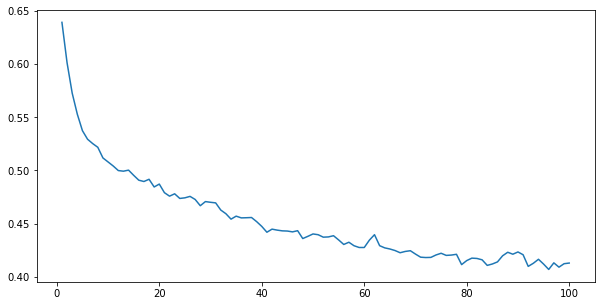

In [17]:
epochs_to_show = 100
smoothing = 0.5
plt.figure(figsize=(10,5))
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_train[0:epochs_to_show],smoothing), label = 'train')
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_valid[0:epochs_to_show],smoothing), label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
# plt.ylim((0.0, 0.9))
# plt.title('loss graph')
plt.show()

print(best_epoch)

In [ ]:
test_data = dataset[train_records+valid_records:total_records]
test_data = test_data.reset_index()

train_data = dataset[0:train_records]
train_data = train.data.reset_index()

In [ ]:
with torch.no_grad():
    x2, x3, c1, c2, c3, c4, num = model(categorical_test_data, numerical_test_data)

In [ ]:
# =============================================================================================
# [22 Juni 2020]: 
# Yang dilaporkan di skripsi adalah hasil di data test, bukan di data validasi yang ada sebelumnya.
# Hasil di validasi hanya untuk eksperimen mencoba-coba hyperparameter hingga hasilnya bagus.
# =============================================================================================

from sklearn.metrics import f1_score

test_val = np.argmax(x3, axis=1)
print(confusion_matrix(test_outputs, test_val))
print(classification_report(test_outputs, test_val))
print("Accuracy: ", accuracy_score(test_outputs, test_val))
print("F1 Score: ", f1_score(test_outputs, test_val, average='macro'))

In [ ]:
embedding = x2.tolist()

In [ ]:
x = embedding

In [ ]:
# =============================================================================================
# [26 Mei 2020]: 
# Visualisasi embedding diganti dari PCA ke t-SNE karena hasil visualisasi PCA kurang 
# representatif. Paper t-SNE: https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf
# =============================================================================================

tsne = TSNE(n_components=2, verbose=1, perplexity=900, n_iter=300)
principalComponents = tsne.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, test_data[['Exited']]], axis = 1)

finalDf0 = finalDf[finalDf['Exited']==0]
finalDf1 = finalDf[finalDf['Exited']==1]

In [ ]:
# visualisasi embedding churn dan not churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Exited'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

In [ ]:
# visualisasi embedding hanya not churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf0['Exited'] == target
    ax.scatter(finalDf0.loc[indicesToKeep, 'principal component 1']
               , finalDf0.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
# visualisasi embedding hanya churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf1['Exited'] == target
    ax.scatter(finalDf1.loc[indicesToKeep, 'principal component 1']
               , finalDf1.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
# =============================================================================================
# [22 Juni 2020]: 
# Selain F1 Score, dilaporkan juga rasio jarak antara embedding intra cluster dan inter cluster
#
# jarak embedding intra cluster adalah jarak antara embedding di suatu kelas ke vector yang ada
# di tengah-tengah kelas tersebut (centroid/center). Jarak diukur dengan Cosine similarity.
# semakin besar angka cosine similarity, semakin kecil jarak yang diukur.
#
# jarak embedding inter cluster adalah jarak antara embedding di suatu kelas ke center dari 
# kelas yang lain (centroid/center). Jarak diukur juga dengan Cosine similarity
#
# Bisa dilihat bahwa dengan tambahan menggunakan autoencoder, inter cluster churn dan 
# inter cluster not churn lebih besar daripada model NN standar. Hal ini berarti bahwa
# penambahan autoencoder bisa membuat keterpisahan antara vektor embedding churn dan tidak churn
#
# Sedangkan untuk jarak intra cluster, model NN standar memberikan hasil yang lebih kecil, sehingga
# dapat disimpulkan NN standar lebih baik daripada metode semi-supervised learning dalam hal 
# pendekatan vektor sesama kelas. 
#
# Namun, jika dihitung rasio antara inter dan intra (inter/intra), model 
# semi-supervised learning memberikan hasil yang lebih baik untuk kelas churn, walaupun NN standar 
# memiliki rasio yang lebih baik untuk kelas not churn
# =============================================================================================

notchurn_emb = x2[test_outputs==0]
sum_notchurn = x2[test_outputs==0].sum(dim=0)
center_notchurn = sum_notchurn/sum_notchurn.norm(p=2)
center_notchurn = center_notchurn.unsqueeze(0)

churn_emb = x2[valid_outputs==1]
sum_churn = x2[valid_outputs==1].sum(dim=0)
center_churn = sum_churn/sum_churn.norm(p=2)
center_churn = center_churn.unsqueeze(0)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

notchurn_centnotchurn_sim = cos(notchurn_emb, center_notchurn).mean()
notchurn_centchurn_sim = cos(notchurn_emb, center_churn).mean()
churn_centchurn_sim = cos(churn_emb, center_churn).mean()
churn_centnotchurn_sim = cos(churn_emb, center_notchurn).mean()

print("emb not churn, center not churn (not churn intra-cluster): ", notchurn_centnotchurn_sim)
print("emb not churn, center churn (not churn inter-cluster): ", notchurn_centchurn_sim)
print("emb churn, center churn (churn intra-cluster): ", churn_centchurn_sim)
print("emb churn, center not churn (churn inter-cluster): ", churn_centnotchurn_sim)

print("not churn inter-intra cluster ratio: ", notchurn_centnotchurn_sim/notchurn_centchurn_sim)
print("churn inter-intra cluster ratio: ", churn_centchurn_sim/churn_centnotchurn_sim)